https://www.pingshiuanchua.com/blog/post/using-youtube-api-to-analyse-youtube-comments-on-python

https://developers.google.com/youtube/v3/docs

https://mp.weixin.qq.com/s?__biz=MzA3OTAxMDQzNQ==&mid=2650634652&idx=1&sn=104cbecc0012c712cdce2e0ab72bd2ab&chksm=87b3d670b0c45f6615d6ac1e0a7e84d91be0ce40d3438fd8ad07c93c60d527ee5fdd58029849&mpshare=1&scene=1&srcid=0624JMdqJbP0ys1upG1tq30M&sharer_sharetime=1592945973355&sharer_shareid=2d100b6ace613eef7480bb415901df3c&exportkey=At1ZMWa1jqV2QNQGaaU%2BcUc%3D&pass_ticket=hNXEM3S%2Bs9yefk1vRE%2FduDaeOI6i9UUJdV4UBrL1mio%3D#rd

https://github.com/stopwords-iso/stopwords-zh/blob/master/stopwords-zh.txt

## Extract YouTube Comments

### Method 1: html

In [1]:
import configparser
from urllib.parse import urlencode
import requests

import time
import json


In [2]:
config = configparser.ConfigParser()
config.read('key.properties')
key = config['google']['python.playground']

**Get Video IDs**

In [3]:
def html_get_videoid(part, maxResults, q, key=key):
    response = requests.get('https://www.googleapis.com/youtube/v3/search?' +
                            urlencode({'part': part,
                                       'maxResults':maxResults,
                                       'q': q,
                                       'key': key}))
    
    search_info = response.json()

    try:
        if response.ok :
            for i in range(maxResults):
                if search_info['items'][i]['snippet']['channelTitle'] == '周杰倫 Jay Chou':
                    video_id = search_info['items'][i]['id']['videoId']
            return video_id
    except IndexError:
        print('Failed to get status, response:', search_info)
        raise

In [4]:
video_id = html_get_videoid(part='snippet', maxResults=5, q='Jay Chou Mojito', key=key)

In [5]:
video_id

'-biOGdYiF-I'

**Get statistics data**

In [6]:
def html_get_statistics_data(video_id, key=key):
    response = requests.get('https://www.googleapis.com/youtube/v3/videos?' +
                            urlencode({'part':'statistics',
                                       'id': video_id,
                                       'key': key}))
    statistics_data = response.json()

    try:
        if response.ok :
            view_count = statistics_data['items'][0]['statistics']['viewCount']
            like_count = statistics_data['items'][0]['statistics']['likeCount']
            dislike_count = statistics_data['items'][0]['statistics']['dislikeCount']
            comment_count = statistics_data['items'][0]['statistics']['commentCount']
            return view_count, like_count, dislike_count, comment_count
    except IndexError:
        print('Failed to get status, response:', statistics_data)
        raise
    
    

In [7]:
view_count, like_count, dislike_count, comment_count = html_get_statistics_data(video_id=video_id, key=key)

In [8]:
print('view_count:', view_count)
print('like_count:', like_count)
print('dislike_count:', dislike_count)
print('comment_count:', comment_count)


view_count: 14817539
like_count: 164641
dislike_count: 7256
comment_count: 16007


**Get comments**

In [9]:
def html_get_comments(part, videoId, key=key):
    time.sleep(1)

    response = requests.get('https://www.googleapis.com/youtube/v3/commentThreads?' +
                        urlencode({'part':part,
                                   'videoId':videoId,
                                   'key': key}))
    resp = response.json()
    resp_tot = resp.copy()
    if 'nextPageToken' in resp:
        page_token = resp['nextPageToken']
        print("resp['nextPageToken']:", resp['nextPageToken'])
        while page_token:
            print('page_token:', page_token)
            response_tk = requests.get('https://www.googleapis.com/youtube/v3/commentThreads?' +
                        urlencode({'part':part,
                                   'pageToken':page_token,
                                   'videoId':videoId,
                                   'key': key}))
            resp_tk = response_tk.json()
            print("len(resp_tk['items']):", len(resp_tk['items']))
            for i in range(len(resp_tk['items'])):
                resp_tot['items'].append(resp_tk['items'][i])
            if 'nextPageToken' in resp_tk:
                page_token = resp_tk['nextPageToken']
                print('page_token:', page_token)
                print('===')
            else:
                break

    return resp_tot


In [10]:
comments_json = html_get_comments(part='snippet', videoId='-biOGdYiF-I', key=key)

resp['nextPageToken']: QURTSl9pMVEzMjRCWTR4d0ZvSXB4QklWYnpwSmRONEFoQVBReHlTQXZKX08yNlZfSXpmZ0FmcUZ6WGh3R0l0b1RQNmZxdTdQeXo4dS1ZX2RSczc1VmpoTVc1dHBGd1M1dVVKQ0RYYmp2TzExR1JjdlJUMDZKX0QwR1pVVlNGRW5IVHc=
page_token: QURTSl9pMVEzMjRCWTR4d0ZvSXB4QklWYnpwSmRONEFoQVBReHlTQXZKX08yNlZfSXpmZ0FmcUZ6WGh3R0l0b1RQNmZxdTdQeXo4dS1ZX2RSczc1VmpoTVc1dHBGd1M1dVVKQ0RYYmp2TzExR1JjdlJUMDZKX0QwR1pVVlNGRW5IVHc=
len(resp_tk['items']): 20
page_token: QURTSl9pM0ppUzRtMnRJaVU3cUM1LWh5XzlIajBjdXlMOEFwXzFWNzVsQW1sblZNUzdYcmtDYmZzS05USFNjOHVEeG9CRTVGT1FUc3BuTEt4QXYtek5UNzVWY2I0MUpNTTl1eGZIUTBaNmo5V0ZQVkVYMW5lZnZTQ2dzeE9ETzdIUVhwUHo3MGx2czRyUms=
===
page_token: QURTSl9pM0ppUzRtMnRJaVU3cUM1LWh5XzlIajBjdXlMOEFwXzFWNzVsQW1sblZNUzdYcmtDYmZzS05USFNjOHVEeG9CRTVGT1FUc3BuTEt4QXYtek5UNzVWY2I0MUpNTTl1eGZIUTBaNmo5V0ZQVkVYMW5lZnZTQ2dzeE9ETzdIUVhwUHo3MGx2czRyUms=
len(resp_tk['items']): 20
page_token: QURTSl9pMXBDWHpGRHFTS3pHbnhsdWQzSVp6OU1VQXJlZjFaNnBCemNSall6dVRCSENZSjYydS1qcVBBX0tGRFZjQUV1TEJsMVpQLWNkeHo1R1B5V2xnRkJ3eGFkRWVhcFRLW

len(resp_tk['items']): 20
page_token: QURTSl9pM0tLSGxsX3EyampPU2NmZV83U3k4THJ0UC1LTW5GLXpucEdNRzBBNWdHNXRNbEwxaGtCcHViN1pGOTVZcEw1N2JnRks3SndJUDA5SkNhclFPRnRST2I3YkkwVW5sV19pQnVjeVVmUm1WZnZ3ZUJfYjEtczlTeG5zNThORGwxekFFNkYyLVgteFdUQVE=
===
page_token: QURTSl9pM0tLSGxsX3EyampPU2NmZV83U3k4THJ0UC1LTW5GLXpucEdNRzBBNWdHNXRNbEwxaGtCcHViN1pGOTVZcEw1N2JnRks3SndJUDA5SkNhclFPRnRST2I3YkkwVW5sV19pQnVjeVVmUm1WZnZ3ZUJfYjEtczlTeG5zNThORGwxekFFNkYyLVgteFdUQVE=
len(resp_tk['items']): 20
page_token: QURTSl9pMG1taFlKZzNlemRvelN2cU9EVTJLQXd4bS1DZFo5b0VpWTRUVVEzaXZxUjRBYlhJUHJrQ2oxWng5WGloM094NVNSOGxwa3RZSWk0eUQwTG1iOFlkY1VxZUk0M18tWFZQZnhyR2VsY2w4am5mQU9kUzlScGdRZUU1Z2hEVHh1bDN5d1MzckFiSnh4amc=
===
page_token: QURTSl9pMG1taFlKZzNlemRvelN2cU9EVTJLQXd4bS1DZFo5b0VpWTRUVVEzaXZxUjRBYlhJUHJrQ2oxWng5WGloM094NVNSOGxwa3RZSWk0eUQwTG1iOFlkY1VxZUk0M18tWFZQZnhyR2VsY2w4am5mQU9kUzlScGdRZUU1Z2hEVHh1bDN5d1MzckFiSnh4amc=
len(resp_tk['items']): 20
page_token: QURTSl9pM2dwa21JUEQwbUlWZGFKZHdzOGUxVzNLSUZhNnI2NVBUQzFsaWl6RWJfQm

len(resp_tk['items']): 20
page_token: QURTSl9pMjZWakRCd2k4TnRJWDBCUnZ1TE1IUmhkbFRneU84YXliQV9HR3d0ajVGOFlxYjhGeWlscFZZRFAwa3pvWkhfR3JxZkwtSDJvczJCeWphal9NUlMtQzJCdWlCZFNORDQ5VVdPQXdycmh2UExwVk1HQ0ZoX2pmdVdmd3RuZDI3cHpTVWpfVlZueV9tcUE=
===
page_token: QURTSl9pMjZWakRCd2k4TnRJWDBCUnZ1TE1IUmhkbFRneU84YXliQV9HR3d0ajVGOFlxYjhGeWlscFZZRFAwa3pvWkhfR3JxZkwtSDJvczJCeWphal9NUlMtQzJCdWlCZFNORDQ5VVdPQXdycmh2UExwVk1HQ0ZoX2pmdVdmd3RuZDI3cHpTVWpfVlZueV9tcUE=
len(resp_tk['items']): 20
page_token: QURTSl9pMXc1TjkyREt6V0dOMm43MWZmSWNLTUpXLVRUS3QxN2RsMHJJV1c3STdRN3Z3cFpIZ2RDU1NGRWZHSlVlaE5mT2lmUHZDOE5pczdKMklJdkhleVdpS2VxdXd3cUotR3JpbVBDYl9ONDROQ20wVUhJc3BOT3dtZUd2UlhqdVN1OXNYNXlYLWZtbm5qU3c=
===
page_token: QURTSl9pMXc1TjkyREt6V0dOMm43MWZmSWNLTUpXLVRUS3QxN2RsMHJJV1c3STdRN3Z3cFpIZ2RDU1NGRWZHSlVlaE5mT2lmUHZDOE5pczdKMklJdkhleVdpS2VxdXd3cUotR3JpbVBDYl9ONDROQ20wVUhJc3BOT3dtZUd2UlhqdVN1OXNYNXlYLWZtbm5qU3c=
len(resp_tk['items']): 20
page_token: QURTSl9pM3JBUi1iTXp5T0htV2ZkRzZqOGN4MENIYWJRYjdUVkdWb0JUQVFpZlpMeG

len(resp_tk['items']): 20
page_token: QURTSl9pMkRUanVfRXBUenlLdGEwbjB2YmxVVTVNNXlnMWJpRHcxRC1NMTNtZGlwaUlwZmh6cEozXzAwaGFzUzM2WC1faVg2ZkhMcUo4bk5vVGdaLXNzVHotWlloeWVvWmFSekV6dzR6ckE5Z3Z3dHNXZ0lrREE3ZnltRF85V253cmt6RzJzOWlfRE1HVGFUTGc=
===
page_token: QURTSl9pMkRUanVfRXBUenlLdGEwbjB2YmxVVTVNNXlnMWJpRHcxRC1NMTNtZGlwaUlwZmh6cEozXzAwaGFzUzM2WC1faVg2ZkhMcUo4bk5vVGdaLXNzVHotWlloeWVvWmFSekV6dzR6ckE5Z3Z3dHNXZ0lrREE3ZnltRF85V253cmt6RzJzOWlfRE1HVGFUTGc=
len(resp_tk['items']): 20
page_token: QURTSl9pMzMwOTNtQnVMT2h4RWQzZmhWMkh5WGlXTWJRT182b2NUNzJpTHE1SnMzcnV3QV9lMFBQZTZibWtRRVlnZWxmRGgzOUpvM1VWTkk1cFROb0N5aWpFZmcwNkZWWWdkSGV0X05sdV9IaGRsY0RpOWVBajVnNndKNmYyZUZ0OWtVOHBjeV9nUFgwTjVGVUE=
===
page_token: QURTSl9pMzMwOTNtQnVMT2h4RWQzZmhWMkh5WGlXTWJRT182b2NUNzJpTHE1SnMzcnV3QV9lMFBQZTZibWtRRVlnZWxmRGgzOUpvM1VWTkk1cFROb0N5aWpFZmcwNkZWWWdkSGV0X05sdV9IaGRsY0RpOWVBajVnNndKNmYyZUZ0OWtVOHBjeV9nUFgwTjVGVUE=
len(resp_tk['items']): 20
page_token: QURTSl9pMUZpZmZxN3Q0R1ZwaGRPQV9qYnNEU1hFcTVvNXlYcWZrWkRncHdLZnRmQl

len(resp_tk['items']): 20
page_token: QURTSl9pMnpLQ0FHYnJCWVhXTkFWYmtUeTVZSmVBNDQxcnNsSUtvdmdzMWlJSnAxeTlnQ1h3X181N094MTVlc0V1WDBBTHpuWGRxVVo2RktpcHNWU1hiT0tFR3lyY1J2TzE0QkRnbS14cUFvbFgtY3Q1ZUl1NDZxODlHNkZhYjB2ZzhxN0d4VXZQT1IxNm83RGc=
===
page_token: QURTSl9pMnpLQ0FHYnJCWVhXTkFWYmtUeTVZSmVBNDQxcnNsSUtvdmdzMWlJSnAxeTlnQ1h3X181N094MTVlc0V1WDBBTHpuWGRxVVo2RktpcHNWU1hiT0tFR3lyY1J2TzE0QkRnbS14cUFvbFgtY3Q1ZUl1NDZxODlHNkZhYjB2ZzhxN0d4VXZQT1IxNm83RGc=
len(resp_tk['items']): 20
page_token: QURTSl9pMUY4YlQ5MWZ4TmZ6WEJUbGQxa3BMM3Q1amJFT0Mxa0JHVm00bFQyd0Rzd2ZvV3BDdXJGdEItRTlHV1lFSGlUYjFrakxqam9wQjJwRnBZc1dyLUd3bUFJZmZ6U3lTSkxZdlphOV80eEwydVhLdVowcklPYndXUXBlaWhUakpsbW1MbTZwVmxnMzZKbkE=
===
page_token: QURTSl9pMUY4YlQ5MWZ4TmZ6WEJUbGQxa3BMM3Q1amJFT0Mxa0JHVm00bFQyd0Rzd2ZvV3BDdXJGdEItRTlHV1lFSGlUYjFrakxqam9wQjJwRnBZc1dyLUd3bUFJZmZ6U3lTSkxZdlphOV80eEwydVhLdVowcklPYndXUXBlaWhUakpsbW1MbTZwVmxnMzZKbkE=
len(resp_tk['items']): 20
page_token: QURTSl9pMnBfUnNGSHJzWVBzRlpYSEo1Y0xWdXVtZFMtbHdFNDBQWG8wQlZ1ZmV3dH

len(resp_tk['items']): 20
page_token: QURTSl9pMHYzSU9HRV9pSVNEcjVDZjh4Qnp3NXBGMDlkTWFrQTRfOWtPYi1GaG4yY184VlJ0cVVwcXFSZGlURElJdFFfTzZhLUJ4OVhhYjdTeXlRRklaem1SMllzeDVITWU0dFVjSGlkNmUydzVBOGFDcnZsbjhZUEdtNDRTR240ajgzTnh2cmxPWTMtWkJtYXc=
===
page_token: QURTSl9pMHYzSU9HRV9pSVNEcjVDZjh4Qnp3NXBGMDlkTWFrQTRfOWtPYi1GaG4yY184VlJ0cVVwcXFSZGlURElJdFFfTzZhLUJ4OVhhYjdTeXlRRklaem1SMllzeDVITWU0dFVjSGlkNmUydzVBOGFDcnZsbjhZUEdtNDRTR240ajgzTnh2cmxPWTMtWkJtYXc=
len(resp_tk['items']): 20
page_token: QURTSl9pMml1cVdlWWhzS3ZpWVVFU0dZMlR5UnBMTDNaelhqcDhYVzNvYTJjcDdjSjJpSVlVQkJZMnFpZ3dJSjF2ajVraWhvYU1RWWNHZ0w2dzhmLWdwMGk2LWpfdDdpV204c3dLTWRmZU1TQUlvdEFhS0FpV2c1S1hhdHdCeVpOaS1EUlUtRlgzRDdCRVhyRlE=
===
page_token: QURTSl9pMml1cVdlWWhzS3ZpWVVFU0dZMlR5UnBMTDNaelhqcDhYVzNvYTJjcDdjSjJpSVlVQkJZMnFpZ3dJSjF2ajVraWhvYU1RWWNHZ0w2dzhmLWdwMGk2LWpfdDdpV204c3dLTWRmZU1TQUlvdEFhS0FpV2c1S1hhdHdCeVpOaS1EUlUtRlgzRDdCRVhyRlE=
len(resp_tk['items']): 20
page_token: QURTSl9pMVFLVjNiWm9wWnEtUmlvZjVBM1ZjenVlbVA2TG95MS1KOW5GNnJWc05uXy

len(resp_tk['items']): 20
page_token: QURTSl9pMl9ZV292LUhEZHlTU2ZPelBCN1h3M0JWUnVsV3RHOUZGTjVMR3pCX2h3UXJfNkE2RGxhYnhWVzdWRUhadDRyRFhsazV0MkcxZThSSmdOeTFuU2JOa0FnYlRqQVB0UURzb2tXR3J5ZWhxdWdTLVJoMXp2QUhXVXR6OG1mT1J3WmpmMkZZQW5FVWh6SUE=
===
page_token: QURTSl9pMl9ZV292LUhEZHlTU2ZPelBCN1h3M0JWUnVsV3RHOUZGTjVMR3pCX2h3UXJfNkE2RGxhYnhWVzdWRUhadDRyRFhsazV0MkcxZThSSmdOeTFuU2JOa0FnYlRqQVB0UURzb2tXR3J5ZWhxdWdTLVJoMXp2QUhXVXR6OG1mT1J3WmpmMkZZQW5FVWh6SUE=
len(resp_tk['items']): 20
page_token: QURTSl9pM3pRWHZjME9FTEM4aUMxUkJFNllrQXdxNUhia2xfQkRScngyUkE5ejgwemZ5ZkNVUUROWUw0a2dfSV9yeHZla1FVeUhuTGt0bFB4SF9kLWNESmxDWWV1MkN4LVdCUFhUbGp4RVZLV1FVdXY0bThTYmcwdFBnc251dGE4aWs4Qnd1Z0lXdDNzOE1CVEE=
===
page_token: QURTSl9pM3pRWHZjME9FTEM4aUMxUkJFNllrQXdxNUhia2xfQkRScngyUkE5ejgwemZ5ZkNVUUROWUw0a2dfSV9yeHZla1FVeUhuTGt0bFB4SF9kLWNESmxDWWV1MkN4LVdCUFhUbGp4RVZLV1FVdXY0bThTYmcwdFBnc251dGE4aWs4Qnd1Z0lXdDNzOE1CVEE=
len(resp_tk['items']): 20
page_token: QURTSl9pMDVsQlYzalU3ZDFnVEJPV2hkSk5RNXRoajNUaV9QR2pId3cteUYxbGhQQm

len(resp_tk['items']): 20
page_token: QURTSl9pM0laQngwNFFZM3hRWmtwWWt2bThmdEcxeDZSV19tM1RMOWprX2NmZlgya0NneXFQQ0t4ZEo2WGp5cndDRWNNMThMWmEzV1JOV1FxaDFyWE4tSkMxUm0yVEJEVWE0UXlGSzlhaHVNSk1YNHRqUVZvYy1SVm5VSUIzQlVKdHR6cGhCbTJIWnNEb3JYZTZz
===
page_token: QURTSl9pM0laQngwNFFZM3hRWmtwWWt2bThmdEcxeDZSV19tM1RMOWprX2NmZlgya0NneXFQQ0t4ZEo2WGp5cndDRWNNMThMWmEzV1JOV1FxaDFyWE4tSkMxUm0yVEJEVWE0UXlGSzlhaHVNSk1YNHRqUVZvYy1SVm5VSUIzQlVKdHR6cGhCbTJIWnNEb3JYZTZz
len(resp_tk['items']): 20
page_token: QURTSl9pMEs0QW94THVnVkJWQjVTd1hCSmYzT1d6Z2lfaVdlTjltSUd1Q3dFXzJuVV9fa1JyZHVMS1VLazhpY3NISWp3RmV0Wm9IQWZJNEZtMFRJMzBYcEw0TzRpN3p0Ymprd0E2bjkxaVFQbFZHQzlSLXRtVEJtYTFrZjZ4VlJURHI4MnN3dklnenYybnlrb1hF
===
page_token: QURTSl9pMEs0QW94THVnVkJWQjVTd1hCSmYzT1d6Z2lfaVdlTjltSUd1Q3dFXzJuVV9fa1JyZHVMS1VLazhpY3NISWp3RmV0Wm9IQWZJNEZtMFRJMzBYcEw0TzRpN3p0Ymprd0E2bjkxaVFQbFZHQzlSLXRtVEJtYTFrZjZ4VlJURHI4MnN3dklnenYybnlrb1hF
len(resp_tk['items']): 20
page_token: QURTSl9pM0pMS0tsQzhoMGR1dXZlWjdUVGxoMU9yM0NjMFhCWF9nUURlX3BnamtkdW

len(resp_tk['items']): 20
page_token: QURTSl9pMXA2cHU4LVFWa3hHQ0lIelI3TURCWi1LQUFyRmFWYTBna2FyOGZMRW40SmhRdEZWNUVIU29pMnBqYzd2WXpuX2JVSVFiUnNmTnYtaUJva0pUQV9KQVBNWnU1d180VmpzUjAtOEdMOFBGQ3huZGJUSVU3M2lkN2QwVXBidXRaSE9tNHppZEwtZEtQbmI4
===
page_token: QURTSl9pMXA2cHU4LVFWa3hHQ0lIelI3TURCWi1LQUFyRmFWYTBna2FyOGZMRW40SmhRdEZWNUVIU29pMnBqYzd2WXpuX2JVSVFiUnNmTnYtaUJva0pUQV9KQVBNWnU1d180VmpzUjAtOEdMOFBGQ3huZGJUSVU3M2lkN2QwVXBidXRaSE9tNHppZEwtZEtQbmI4
len(resp_tk['items']): 20
page_token: QURTSl9pMThyS1MwWnBRSkJWNHRZR1Y3bEh5cFlCNTN2eU5LZnlRa1JfRWtnT3k1UXNhMHpmVWhtNHZHbmVxa2pLWjBtZldjU2hnTnZHa25PSE9EcUYzN3d0YVlyLXMxSUx0RUwwNEsxMUI3YXp2ZXozT3IyX0IxcFIzdXkzZUplU3VSVkpRV0NJNUZtZkZEU2xZ
===
page_token: QURTSl9pMThyS1MwWnBRSkJWNHRZR1Y3bEh5cFlCNTN2eU5LZnlRa1JfRWtnT3k1UXNhMHpmVWhtNHZHbmVxa2pLWjBtZldjU2hnTnZHa25PSE9EcUYzN3d0YVlyLXMxSUx0RUwwNEsxMUI3YXp2ZXozT3IyX0IxcFIzdXkzZUplU3VSVkpRV0NJNUZtZkZEU2xZ
len(resp_tk['items']): 20
page_token: QURTSl9pMDRJN3NVWjc2ZEwyOEd0SF9SNlZBWjA3Mk5ZWnl0djVmTmhqVFpaT0tCWU

len(resp_tk['items']): 20
page_token: QURTSl9pMDJxUFR0MDVmLTFvS2V2NUczWHBlWVBJNmZwZ2E0QzZxc2x6eE1wZGVKQTVSdkFtMkd2WVliLV9CNFVaNDFhZVB1WFdyaWc2VURzRTVvQUpYVGNJNnF1cE1uRzBpbVZrRTVZQUhiaGJqOHRCQ0R5c3ExZ096SmhxeGlIaE83OXQwcEFLWXZEUml4Y0Jz
===
page_token: QURTSl9pMDJxUFR0MDVmLTFvS2V2NUczWHBlWVBJNmZwZ2E0QzZxc2x6eE1wZGVKQTVSdkFtMkd2WVliLV9CNFVaNDFhZVB1WFdyaWc2VURzRTVvQUpYVGNJNnF1cE1uRzBpbVZrRTVZQUhiaGJqOHRCQ0R5c3ExZ096SmhxeGlIaE83OXQwcEFLWXZEUml4Y0Jz
len(resp_tk['items']): 20
page_token: QURTSl9pMVFhc2haTlhiQ3huOGFGcktJazMxeWFTZDVoRXo3M0Rzb3VXMjlQQXBEVnJMOFhDVlYtUEdCcktQMlM3b3pyeG9wTkplUXFkc3YxRjVnMkcwblRiWWNuenZWcERrOFdEQWhNdVNwQTBpeXZVMDBwZUswbnl1QUt4bEg4TjktTGFtRGFFeTh0Y3hfTFhR
===
page_token: QURTSl9pMVFhc2haTlhiQ3huOGFGcktJazMxeWFTZDVoRXo3M0Rzb3VXMjlQQXBEVnJMOFhDVlYtUEdCcktQMlM3b3pyeG9wTkplUXFkc3YxRjVnMkcwblRiWWNuenZWcERrOFdEQWhNdVNwQTBpeXZVMDBwZUswbnl1QUt4bEg4TjktTGFtRGFFeTh0Y3hfTFhR
len(resp_tk['items']): 20
page_token: QURTSl9pMkNOcndGUmV0RmJiRHJhTXEtV1FmcnFLSl9JdTAwQUg0OGpSRk1NNU9acl

len(resp_tk['items']): 20
page_token: QURTSl9pMFp6ZjhBdm9hdmFxbTZvY0dtamF6dGg2ellJLTdJa0gyTlZfNjgtTTc0WmJXZWtzc3I4Tnp0NThpVmE5R0hKdkU4dkNDVTJYWFdPakstOEFVVExIMzFtdUhKV0tSWGFfbUZLR0RmZi1oZVdyRmxDcXJmQzRCOEs3V2RjZUlQNjhLZ0h0a0Z3cjBnekVj
===
page_token: QURTSl9pMFp6ZjhBdm9hdmFxbTZvY0dtamF6dGg2ellJLTdJa0gyTlZfNjgtTTc0WmJXZWtzc3I4Tnp0NThpVmE5R0hKdkU4dkNDVTJYWFdPakstOEFVVExIMzFtdUhKV0tSWGFfbUZLR0RmZi1oZVdyRmxDcXJmQzRCOEs3V2RjZUlQNjhLZ0h0a0Z3cjBnekVj
len(resp_tk['items']): 20
page_token: QURTSl9pMEt5QnU2TUREYVJ4cVMyZThlX1NKbXM0akdfNGFXRzJIb1pVaFE4aUdFVkpHQmRBd0g1WXZjUVJhcldFMW9fSGd6WHRUOFQwd2FHZGN6LTdtY0NKM3c1ZXpWSlJXTDV1Y29fbjNsYndVYlc5Z3VjOWcwSTNyYTRLSmxFT3A5N3ZMTkJjR2xBM1d3aWRZ
===
page_token: QURTSl9pMEt5QnU2TUREYVJ4cVMyZThlX1NKbXM0akdfNGFXRzJIb1pVaFE4aUdFVkpHQmRBd0g1WXZjUVJhcldFMW9fSGd6WHRUOFQwd2FHZGN6LTdtY0NKM3c1ZXpWSlJXTDV1Y29fbjNsYndVYlc5Z3VjOWcwSTNyYTRLSmxFT3A5N3ZMTkJjR2xBM1d3aWRZ
len(resp_tk['items']): 20
page_token: QURTSl9pMFdOTlU5VzhXczFMWFNqZF9lVVFsX0lUTl9VUDBLcHZmOFdCZEFyRkNLZX

len(resp_tk['items']): 20
page_token: QURTSl9pMlphVHNzbmVFTXh0TjdJVC1BcjdtTktvRW5uWlBlSFBuZlpLbzd3MWQ4WWdkeFp4LWxQOXZ4MC11TWRab09BUzk1dHhvNFJlYXhSSG5DYVdWUGVJYk5HdUdiaTVXR2pkVVdQTkY1bGFSVTh3N2NMRnZ2MmpVYUhXWWx5T1dOazk4b01zbEo3Q1FsREhr
===
page_token: QURTSl9pMlphVHNzbmVFTXh0TjdJVC1BcjdtTktvRW5uWlBlSFBuZlpLbzd3MWQ4WWdkeFp4LWxQOXZ4MC11TWRab09BUzk1dHhvNFJlYXhSSG5DYVdWUGVJYk5HdUdiaTVXR2pkVVdQTkY1bGFSVTh3N2NMRnZ2MmpVYUhXWWx5T1dOazk4b01zbEo3Q1FsREhr
len(resp_tk['items']): 20
page_token: QURTSl9pMlpYUE9tRG5xdWRjNmludlNrX3o1aGxDbTA0NGFzckFyQkRxSXUwRFd6QVhfZ3Y2MERMWEJHWXI4VmxacXA2WmpuQ09odllKSk9jcHV0ZDdsWkV6bmFtZHg2UWNRVTF5MmwwejBxVVJDTWFTeXdmMHMtNEs5Q3IwSG1XbTlIZ0lkejMwdEY1Zmhpbm1F
===
page_token: QURTSl9pMlpYUE9tRG5xdWRjNmludlNrX3o1aGxDbTA0NGFzckFyQkRxSXUwRFd6QVhfZ3Y2MERMWEJHWXI4VmxacXA2WmpuQ09odllKSk9jcHV0ZDdsWkV6bmFtZHg2UWNRVTF5MmwwejBxVVJDTWFTeXdmMHMtNEs5Q3IwSG1XbTlIZ0lkejMwdEY1Zmhpbm1F
len(resp_tk['items']): 20
page_token: QURTSl9pMVpPdGs0d0xxaHBJQUw0MmZzSENyc0JmVmpyNGpjc2U3YnlSMW5JcHVNRn

len(resp_tk['items']): 20
page_token: QURTSl9pM1phS1pBOUZPOWsxdVpIQUh3TTZBTldKbm4zakFFazNQb3VsanRNV3QyQXNod0ZHQXB6SlhwWGVrdk9KNVZSZGJfUTh2UGlCX21WclJUMUZ2LUpWbFNWQjdWN0Izal9ENGFpS2NhNkloaTZ0Ql9wYkRpV3VJTlB5VlBwTU9GRHRTVmtHYkZDMHVxQnBR
===
page_token: QURTSl9pM1phS1pBOUZPOWsxdVpIQUh3TTZBTldKbm4zakFFazNQb3VsanRNV3QyQXNod0ZHQXB6SlhwWGVrdk9KNVZSZGJfUTh2UGlCX21WclJUMUZ2LUpWbFNWQjdWN0Izal9ENGFpS2NhNkloaTZ0Ql9wYkRpV3VJTlB5VlBwTU9GRHRTVmtHYkZDMHVxQnBR
len(resp_tk['items']): 20
page_token: QURTSl9pMDF6V3NWT1Y3cVZId2RHVHo3NVFJRm1MNWJGR1lROFpBeDIyTm1EbDVuWWpHQloycTBzbUw3d1NpN1p1M3c0eHl1MTBMSVBqeTlUV1ZZc3F2QlR6LWc4c0hRMUpYVDl6Z2ViM1JfRXlPWWh6bmpfSk1PenIyWE1KQ3ZCNTBjTnBuWkNYSFNWcjZFd1dv
===
page_token: QURTSl9pMDF6V3NWT1Y3cVZId2RHVHo3NVFJRm1MNWJGR1lROFpBeDIyTm1EbDVuWWpHQloycTBzbUw3d1NpN1p1M3c0eHl1MTBMSVBqeTlUV1ZZc3F2QlR6LWc4c0hRMUpYVDl6Z2ViM1JfRXlPWWh6bmpfSk1PenIyWE1KQ3ZCNTBjTnBuWkNYSFNWcjZFd1dv
len(resp_tk['items']): 20
page_token: QURTSl9pMDBzQzhTQl9Xd1JDUDZFalZPbjZXMnkybHFOamZ1cUc4dEhYMVVZWUNBUW

len(resp_tk['items']): 20
page_token: QURTSl9pM2ljUWJHeU1oTHJqUTZiaURRQW82cVg4dEJXbzRXRVg1WGZITmU1dU5kSWpBRkozby1vLWZhRW5BVHdEVTJyeVpUU1MzWEFXMlN1Z0dnelhDOUg1NUdKeUF3X0Q2bER3ckZqd3ExN0RaMU43bXNHRkl2OGVKRXl1UnJIcG41OUlieVNzUHlpMlpaZGZB
===
page_token: QURTSl9pM2ljUWJHeU1oTHJqUTZiaURRQW82cVg4dEJXbzRXRVg1WGZITmU1dU5kSWpBRkozby1vLWZhRW5BVHdEVTJyeVpUU1MzWEFXMlN1Z0dnelhDOUg1NUdKeUF3X0Q2bER3ckZqd3ExN0RaMU43bXNHRkl2OGVKRXl1UnJIcG41OUlieVNzUHlpMlpaZGZB
len(resp_tk['items']): 20
page_token: QURTSl9pMDFyZzY5YTVOZFVuWHRNNGJHUkFoWnQtZlpEVV9nZGQzMXk5RWlIQ0FXUEsyangwd08zVlpndVJ2Q3hpMWpMUnpUeHJFWDFjQWoteG9acG1QRVFSYUdoblF1TmtfZ01KSXJ1RUY3UHk0VHBmcmtlbDgtb2s4NXJTbmRUbzdXT3ZXMFpSdmUwNmd0QzNv
===
page_token: QURTSl9pMDFyZzY5YTVOZFVuWHRNNGJHUkFoWnQtZlpEVV9nZGQzMXk5RWlIQ0FXUEsyangwd08zVlpndVJ2Q3hpMWpMUnpUeHJFWDFjQWoteG9acG1QRVFSYUdoblF1TmtfZ01KSXJ1RUY3UHk0VHBmcmtlbDgtb2s4NXJTbmRUbzdXT3ZXMFpSdmUwNmd0QzNv
len(resp_tk['items']): 20
page_token: QURTSl9pMnBycEQwcGFyWmdnOWFsa0ZfNHpETldHR2I5Q0tYdWFoNjJqMjNpeDhvNE

len(resp_tk['items']): 20
page_token: QURTSl9pMXRZcUVXMmxOS1Z0WUJWRDBtZUpPYVNqcjRTY1JvUkkwbkV0WGZkM1FmTk1lTnYxcTVYdVI2cTludlhTdHNSaGo1elNZdk1tSTNGdXNqd3FlSzA3N3p2dGstWXFmTWN1dUJQRG14YzBVTzFZczRrZWNsNXc1MzV2cEZRTTJlRnpOaEVoVzktQ3FoMV9N
===
page_token: QURTSl9pMXRZcUVXMmxOS1Z0WUJWRDBtZUpPYVNqcjRTY1JvUkkwbkV0WGZkM1FmTk1lTnYxcTVYdVI2cTludlhTdHNSaGo1elNZdk1tSTNGdXNqd3FlSzA3N3p2dGstWXFmTWN1dUJQRG14YzBVTzFZczRrZWNsNXc1MzV2cEZRTTJlRnpOaEVoVzktQ3FoMV9N
len(resp_tk['items']): 20
page_token: QURTSl9pMHphQnNqZlJRTjBQOGtRV2RjM0oxUWt5bHktRjFGYzk1RnpZUkEyVUpUQnJSWEwwa3d5a04tTnN1djktQVFVdzMwbGRQN213elBUNkRCeDhDSXUxOUZkMXgtc25GeFNoWWQ5LV9JOXplLWJFMFNOak96M0RIRE1IdUFlMmp0M2UxZ0VPcUVWLXdWSm9B
===
page_token: QURTSl9pMHphQnNqZlJRTjBQOGtRV2RjM0oxUWt5bHktRjFGYzk1RnpZUkEyVUpUQnJSWEwwa3d5a04tTnN1djktQVFVdzMwbGRQN213elBUNkRCeDhDSXUxOUZkMXgtc25GeFNoWWQ5LV9JOXplLWJFMFNOak96M0RIRE1IdUFlMmp0M2UxZ0VPcUVWLXdWSm9B
len(resp_tk['items']): 20
page_token: QURTSl9pMmg0Z0s2Y3E2X0JPVWVqTzhzQ2J6RXZoWlJSblpGbTBrZV9xQjdsOFhsS3

len(resp_tk['items']): 20
page_token: QURTSl9pM1lRTVlVYTg0TndIOWZ0d0gxZnpzX05yZS02ZUhXd0FIZ0E3SFRzaElIbGM5UExNVHAxbjlydVdYYWhpZW1vVE9UTHdhYV84U0RIMWRMVjNaU3A3b0p2Q2xqZkJJN3AwTmh6cjhxQnVkZEliTHlEUWpFc2llZ3hkOUZkRkN4cnVWanhZblRWYUh1NnFv
===
page_token: QURTSl9pM1lRTVlVYTg0TndIOWZ0d0gxZnpzX05yZS02ZUhXd0FIZ0E3SFRzaElIbGM5UExNVHAxbjlydVdYYWhpZW1vVE9UTHdhYV84U0RIMWRMVjNaU3A3b0p2Q2xqZkJJN3AwTmh6cjhxQnVkZEliTHlEUWpFc2llZ3hkOUZkRkN4cnVWanhZblRWYUh1NnFv
len(resp_tk['items']): 20
page_token: QURTSl9pMEpndVJULUZoUmNZS3NPUkxDX1ZxOHJvQlpTLW9Ob1hhMjk3VUhsaWN5U1Jrd0lsQ1BQZFRhbHdCalVOa3l2ZV82N2p3cWFLYUgzQjUtSGstQnd1a2xUb2IwTGNuMXo0LWVNRzlCcVMzak5QbUNOZjVHb0VQcjdmMjE2aFdtcFNuSUF0U2R0QW1IbmJF
===
page_token: QURTSl9pMEpndVJULUZoUmNZS3NPUkxDX1ZxOHJvQlpTLW9Ob1hhMjk3VUhsaWN5U1Jrd0lsQ1BQZFRhbHdCalVOa3l2ZV82N2p3cWFLYUgzQjUtSGstQnd1a2xUb2IwTGNuMXo0LWVNRzlCcVMzak5QbUNOZjVHb0VQcjdmMjE2aFdtcFNuSUF0U2R0QW1IbmJF
len(resp_tk['items']): 20
page_token: QURTSl9pMlRhNTZ1VVBSSGVSMjY3TkpwNEozSXlRSEp5bGxLWU5rUzBhSGpHOGc2cm

len(resp_tk['items']): 20
page_token: QURTSl9pMkNEVExxSlJFcXB6b2ZvYjBDMUZ6dnNqcTUxU2k0QlZPeU5USnY3ZnB1bWttQl9zSmZocW1uR2M0MlB0dDZTRkRIZFViOEpKQmJ5dUs1UkJ0UWVYUXN6aFY1NXBZaTVOMFZEN3FnTm9HMnFyVENZRnJ4RHItMEFWUDVJOW1kc3hoZE1nNm05RUp0TnBB
===
page_token: QURTSl9pMkNEVExxSlJFcXB6b2ZvYjBDMUZ6dnNqcTUxU2k0QlZPeU5USnY3ZnB1bWttQl9zSmZocW1uR2M0MlB0dDZTRkRIZFViOEpKQmJ5dUs1UkJ0UWVYUXN6aFY1NXBZaTVOMFZEN3FnTm9HMnFyVENZRnJ4RHItMEFWUDVJOW1kc3hoZE1nNm05RUp0TnBB
len(resp_tk['items']): 20
page_token: QURTSl9pMmhwVXg2eVFyUHBOV0VTcGR1S2djTFJDX2ljUkRiNHlxV282YTl4TVktRkFSWGlOVU5XM2RsdGo1T3piN0kwaGpCUWhuTkY3RWJ2WW5ZNGVxOE1QSXl0ZHU4amRuVVB1T09LTFNpYk91NW9lYTlpM2NuZmRQN3JDTXA2ZlRXRmZBUE00RlV2NU9ZeXBr
===
page_token: QURTSl9pMmhwVXg2eVFyUHBOV0VTcGR1S2djTFJDX2ljUkRiNHlxV282YTl4TVktRkFSWGlOVU5XM2RsdGo1T3piN0kwaGpCUWhuTkY3RWJ2WW5ZNGVxOE1QSXl0ZHU4amRuVVB1T09LTFNpYk91NW9lYTlpM2NuZmRQN3JDTXA2ZlRXRmZBUE00RlV2NU9ZeXBr
len(resp_tk['items']): 20
page_token: QURTSl9pMVN2ZWFaenhnaGc0Qm9GM0xRNmVMVHJZQXNvcGg0WmYwdlVxbVZjM1lpc2

len(resp_tk['items']): 20
page_token: QURTSl9pMGdiU1NKSXZxcjZDZUpSRWd1aUpYRjkyS2xzQi1GU0tXNU9oeG55aVZXcGtQXzdiSll2NVYzVGs0Slllbk5YN2hWWkRlWkdBZHNkUTlka0trNEdpdjlkazdPNFR0SFNlT3gxZnZ5bkt5VTNhMEZTcWw0ZVlYVWRrVzl2Zm11VVd3eng3V1RyOGdCUEQ4
===
page_token: QURTSl9pMGdiU1NKSXZxcjZDZUpSRWd1aUpYRjkyS2xzQi1GU0tXNU9oeG55aVZXcGtQXzdiSll2NVYzVGs0Slllbk5YN2hWWkRlWkdBZHNkUTlka0trNEdpdjlkazdPNFR0SFNlT3gxZnZ5bkt5VTNhMEZTcWw0ZVlYVWRrVzl2Zm11VVd3eng3V1RyOGdCUEQ4
len(resp_tk['items']): 20
page_token: QURTSl9pM2pQSlVqczJTeGVKcU4zdzV2bVdENHdzNWtYS0xsa0c1OFpSbmFwRTZfazFESG0tWTJRM0ZMc3ZxcXU2Q1hLM2pEc3pFdnhFVTNIbE1QY3BxUE9pcjlrM3djYjB6WUhmbFJSQXRWY1FoNjRDbUstNUV6ZDRldGJucjQteUZnUnd1S3hfTERGYzZLWldn
===
page_token: QURTSl9pM2pQSlVqczJTeGVKcU4zdzV2bVdENHdzNWtYS0xsa0c1OFpSbmFwRTZfazFESG0tWTJRM0ZMc3ZxcXU2Q1hLM2pEc3pFdnhFVTNIbE1QY3BxUE9pcjlrM3djYjB6WUhmbFJSQXRWY1FoNjRDbUstNUV6ZDRldGJucjQteUZnUnd1S3hfTERGYzZLWldn
len(resp_tk['items']): 20
page_token: QURTSl9pM2FTdVBvTjh1a19DWWxvYmVqWDNtYzBZdXFCVlRZM1dHbDFOd2ZMUnJjS1

len(resp_tk['items']): 20
page_token: QURTSl9pMzR6RE5rbDRUMGR1Q0RFbVJSRFVSZGxzak55ZlpObjJlT1ZCLVp3ZDl2T0JHT3F4UDdGTEtKQUJQYlRZOHJUTlJDY0NBUmNXVlVQdGhZTEVxQnJmTVhpWGVic2t4ZFNCU2ZDOExCNkQtY2daNExlamRDMXhxc05OVVl3TlFja25DRnZsS1l5Q0k0OHJj
===
page_token: QURTSl9pMzR6RE5rbDRUMGR1Q0RFbVJSRFVSZGxzak55ZlpObjJlT1ZCLVp3ZDl2T0JHT3F4UDdGTEtKQUJQYlRZOHJUTlJDY0NBUmNXVlVQdGhZTEVxQnJmTVhpWGVic2t4ZFNCU2ZDOExCNkQtY2daNExlamRDMXhxc05OVVl3TlFja25DRnZsS1l5Q0k0OHJj
len(resp_tk['items']): 20
page_token: QURTSl9pMFNIMlhsRk4xbnZya2FsRmtNcmVHNmpLRkROaVlkbkRaUEgwRjlVZFBkMUcwMkhCNGh6cG9pTnNoN2tJOEVjb3ZROVd6c2x4M05KSmFDWDBqNXctOEJ3M2JnZUNnT1ZfQjlhVTVZaGtLOHFnaGFxQUVKbl9lZlUyM3JnYUVtNFU3YmJkcUNyTV9hRXhj
===
page_token: QURTSl9pMFNIMlhsRk4xbnZya2FsRmtNcmVHNmpLRkROaVlkbkRaUEgwRjlVZFBkMUcwMkhCNGh6cG9pTnNoN2tJOEVjb3ZROVd6c2x4M05KSmFDWDBqNXctOEJ3M2JnZUNnT1ZfQjlhVTVZaGtLOHFnaGFxQUVKbl9lZlUyM3JnYUVtNFU3YmJkcUNyTV9hRXhj
len(resp_tk['items']): 20
page_token: QURTSl9pMzdmY1JMRHZZZmtjM3NpUXROUEV5SHc5bEhvX19SdEp5U044cjJmYXctSW

len(resp_tk['items']): 20
page_token: QURTSl9pMlBMZXNBbURxZkhwSUdLREE5ZG9IVjZwLVZNeFFoUF92OVZVRWRyTzR3Q3M3aVplS0t0RENVdmZocUt4RVNRMjZuSlczS1FOYUV1Nk51LWcwbFBiOWFhcjBsMEZxQjYwazdQNDlZc1ZuYjNTc3VBVHE5QW9KT1FqdGpOX1Zwd2VCZ0MwQjRobjlKT0Q4
===
page_token: QURTSl9pMlBMZXNBbURxZkhwSUdLREE5ZG9IVjZwLVZNeFFoUF92OVZVRWRyTzR3Q3M3aVplS0t0RENVdmZocUt4RVNRMjZuSlczS1FOYUV1Nk51LWcwbFBiOWFhcjBsMEZxQjYwazdQNDlZc1ZuYjNTc3VBVHE5QW9KT1FqdGpOX1Zwd2VCZ0MwQjRobjlKT0Q4
len(resp_tk['items']): 20
page_token: QURTSl9pMDMtR3FqWlE5b0FaRUFBQkxUQkRDeExpUXp6b1lZSE8tbUczU3BpY3dIR2xPN1dWREFZcTdmS3hhLVFfTkdYOFc1akFDdEh2QmNGOFBLQVpmR3N0bmxNeDlaN1JWTHJhMGxIeV9QUHBOV3lKWDlFTlRRclJEbDZyQVZLeTlIZUh4X24tYzg0ek9PcnlZ
===
page_token: QURTSl9pMDMtR3FqWlE5b0FaRUFBQkxUQkRDeExpUXp6b1lZSE8tbUczU3BpY3dIR2xPN1dWREFZcTdmS3hhLVFfTkdYOFc1akFDdEh2QmNGOFBLQVpmR3N0bmxNeDlaN1JWTHJhMGxIeV9QUHBOV3lKWDlFTlRRclJEbDZyQVZLeTlIZUh4X24tYzg0ek9PcnlZ
len(resp_tk['items']): 20
page_token: QURTSl9pM1NJZWFvMUduTmRuRkpMRnRabmNYeUFkUnhzSXdYZHdQVTJ2aXdscTh0M0

len(resp_tk['items']): 20
page_token: QURTSl9pMjRzTGJhTjBtSy1qN2J5LTk0ZnBVSEZvZ0ptTEwyZ09DYzZqdmVyUzMwQjdoVUVIbDVqNUUyRDNYRC0wNTE2VGtGT05uN3FXMmgwX2thVWV1MURhOWJxMlNRNnVibmQtVmpwNDl3QXFuVnRBeU5FYmFvdGFiMWVIeWFDbm1mend0VEhXOG1JTDBzQjdZ
===
page_token: QURTSl9pMjRzTGJhTjBtSy1qN2J5LTk0ZnBVSEZvZ0ptTEwyZ09DYzZqdmVyUzMwQjdoVUVIbDVqNUUyRDNYRC0wNTE2VGtGT05uN3FXMmgwX2thVWV1MURhOWJxMlNRNnVibmQtVmpwNDl3QXFuVnRBeU5FYmFvdGFiMWVIeWFDbm1mend0VEhXOG1JTDBzQjdZ
len(resp_tk['items']): 20
page_token: QURTSl9pMEsxZDRsUjM4ZkMya2IxOG9RN01xY1J6RU5OaVpUNjZRam9PbmdsSEc4cU9TX3U1VTB1MDdhZFJnODg2NVl3NHBDYTJxanFjR1ZyRVJIMkYtNkwzVFdUN0RhWC1zTEg4M05jOUltOV9VNTRVaUpuM3lvT2U0T1cwT1FxVG9DMmR6WGx2eUFHZjBmR1ZR
===
page_token: QURTSl9pMEsxZDRsUjM4ZkMya2IxOG9RN01xY1J6RU5OaVpUNjZRam9PbmdsSEc4cU9TX3U1VTB1MDdhZFJnODg2NVl3NHBDYTJxanFjR1ZyRVJIMkYtNkwzVFdUN0RhWC1zTEg4M05jOUltOV9VNTRVaUpuM3lvT2U0T1cwT1FxVG9DMmR6WGx2eUFHZjBmR1ZR
len(resp_tk['items']): 20
page_token: QURTSl9pM0c2c1JkOExjbzZ2cGE3UjFLOXdjTWhKSzhITmlfWHdfcm5mUUJwcllseE

len(resp_tk['items']): 20
page_token: QURTSl9pM0lYSDE4S25xeFFmOVZKeDU3ZmtqQnhjYUVPNjBDLURKMWIzN0lUTDRYbUhabmdZbEN1MjhZU0hpbl9VRFpEUENSTW5QODJTbzJOd1NSMmlQYmV1UjFzQUkwWVV3UDdmUUE1Q19NUVFwQzEtNjFfT0RwZWhLZFVvNE82Nm5hSWZ3T1AtV3VKak9Ybkhr
===
page_token: QURTSl9pM0lYSDE4S25xeFFmOVZKeDU3ZmtqQnhjYUVPNjBDLURKMWIzN0lUTDRYbUhabmdZbEN1MjhZU0hpbl9VRFpEUENSTW5QODJTbzJOd1NSMmlQYmV1UjFzQUkwWVV3UDdmUUE1Q19NUVFwQzEtNjFfT0RwZWhLZFVvNE82Nm5hSWZ3T1AtV3VKak9Ybkhr
len(resp_tk['items']): 20
page_token: QURTSl9pM1ZSMnc0U2o1X2VzY2wzMU44b2dhNG9GZHR3SmtfZkk1dmxUMG9zVzNlY1R3S1VXV1NNYllFRHluUTM5Y2VIU1hWalN3MHN1MWg3dkhEdUJ5b0pXQWx0cjV2dVNlaVdfeDVseHJmQ3lKUENHZEQyd3R1dHFMTmxDTnhNZGNVMFAxRmNpODZ6c0xjemc4
===
page_token: QURTSl9pM1ZSMnc0U2o1X2VzY2wzMU44b2dhNG9GZHR3SmtfZkk1dmxUMG9zVzNlY1R3S1VXV1NNYllFRHluUTM5Y2VIU1hWalN3MHN1MWg3dkhEdUJ5b0pXQWx0cjV2dVNlaVdfeDVseHJmQ3lKUENHZEQyd3R1dHFMTmxDTnhNZGNVMFAxRmNpODZ6c0xjemc4
len(resp_tk['items']): 20
page_token: QURTSl9pMXlBOU9HaXNuUjlyOWVRaGdPY0FIT2p3WEVjY0dXbWlRTGpIQWY2YTZrYW

len(resp_tk['items']): 20
page_token: QURTSl9pMi1ETTR4WlFFS0x4eWtJSEFqREJrajZTbkwyN3hDM0pKUG01Nm5US0dGbGhpTnFKY2EzSVBOYTYwc19xTEJzZlZpWnNNQWp1Y0d1MjlPTFJwYkxJMUlTbEVsVGNiZzdWXzZGSGVWc2xJaTlYc1NWQjJKdkpham9ESlQ5UDl2bkdsYnQ5YjZ0VXZTQUJn
===
page_token: QURTSl9pMi1ETTR4WlFFS0x4eWtJSEFqREJrajZTbkwyN3hDM0pKUG01Nm5US0dGbGhpTnFKY2EzSVBOYTYwc19xTEJzZlZpWnNNQWp1Y0d1MjlPTFJwYkxJMUlTbEVsVGNiZzdWXzZGSGVWc2xJaTlYc1NWQjJKdkpham9ESlQ5UDl2bkdsYnQ5YjZ0VXZTQUJn
len(resp_tk['items']): 20
page_token: QURTSl9pMndPQUFQV1ljZXVfcExUNFRUVUZiaUt1UWFPbGRVYVRMazFvckd2MXJDMzhOcFA2RGJSX1ZlcXg3em9jT0NPak8yUUxpTlJzbUo1Z2ZLWkVUbXlIdmJBdkJxeV83TFhWOXl4N3VyU0lVeUdlZVVUSkdHdHp3RUs4NUZPYWVUNElvNnFYNzFaanNtME5z
===
page_token: QURTSl9pMndPQUFQV1ljZXVfcExUNFRUVUZiaUt1UWFPbGRVYVRMazFvckd2MXJDMzhOcFA2RGJSX1ZlcXg3em9jT0NPak8yUUxpTlJzbUo1Z2ZLWkVUbXlIdmJBdkJxeV83TFhWOXl4N3VyU0lVeUdlZVVUSkdHdHp3RUs4NUZPYWVUNElvNnFYNzFaanNtME5z
len(resp_tk['items']): 20
page_token: QURTSl9pM2ozeE1Pc2ZFUEs3VDlNWW1RNXQ5cmZXTEM3cWtRUUxNWUpHZzdZXzh6Nm

len(resp_tk['items']): 20
page_token: QURTSl9pMzRnX0dGZERkQldHRjBNMjU2OTEtOW1fUlphUXNYQkswd1BSR194cEdHSGhoUDB3c2IwcTBNbTRtcXJhdm5ENXVfZU53QnJMQkljTUVkbmdUYWVMcHZWX1dtbWVYcno4U0JhY1UxSjFjdnE3c1BrMG1ybFJfNWIyY2VMLVc1QnVzLWd0YWNMZV91ZklR
===
page_token: QURTSl9pMzRnX0dGZERkQldHRjBNMjU2OTEtOW1fUlphUXNYQkswd1BSR194cEdHSGhoUDB3c2IwcTBNbTRtcXJhdm5ENXVfZU53QnJMQkljTUVkbmdUYWVMcHZWX1dtbWVYcno4U0JhY1UxSjFjdnE3c1BrMG1ybFJfNWIyY2VMLVc1QnVzLWd0YWNMZV91ZklR
len(resp_tk['items']): 20
page_token: QURTSl9pM1BReGF2STg5X18zMW52cVJKMm9zWlZUSmR0dVVDV242V1AxNGRPRGZTbl9nQTNzNjEzdVJqWFV2RDQ2bm5fZk1ZUUNTeUw4LU1ySnVhYkRTVlh3QndXNm1KTFZDTThqQVlhalZvNWx5WV85MzdmV1JHcmN5WmlheTNua0prajRZd1FQcERhdG51dmIw
===
page_token: QURTSl9pM1BReGF2STg5X18zMW52cVJKMm9zWlZUSmR0dVVDV242V1AxNGRPRGZTbl9nQTNzNjEzdVJqWFV2RDQ2bm5fZk1ZUUNTeUw4LU1ySnVhYkRTVlh3QndXNm1KTFZDTThqQVlhalZvNWx5WV85MzdmV1JHcmN5WmlheTNua0prajRZd1FQcERhdG51dmIw
len(resp_tk['items']): 20
page_token: QURTSl9pMEIzUW5IT2NfcV9VUE9PWHd4NkJJRUphbUJrT0dRLXJ2bld1R2xMV28xWF

len(resp_tk['items']): 20
page_token: QURTSl9pM1doZUU3VGw3MmdLUk5DdGl5aEw1cjlYOFFCY3VHektZS2RtbzlPTjhuTTJURDMzMF8zUnFieUFNaHJ2LWtHbGc2ZDZMZ1VtNF84cjlxV0xTMWlFaTJxWlJIV25GMWJWYUhPeFBhSFJGZVB6eGd4M2tfeWZfU080ei1MdktxTGdfOHREMEVRWFZEek9V
===
page_token: QURTSl9pM1doZUU3VGw3MmdLUk5DdGl5aEw1cjlYOFFCY3VHektZS2RtbzlPTjhuTTJURDMzMF8zUnFieUFNaHJ2LWtHbGc2ZDZMZ1VtNF84cjlxV0xTMWlFaTJxWlJIV25GMWJWYUhPeFBhSFJGZVB6eGd4M2tfeWZfU080ei1MdktxTGdfOHREMEVRWFZEek9V
len(resp_tk['items']): 20
page_token: QURTSl9pMXRMclRwaUhhNWIxSGUtc3VyR2lKcEs5VG85S3I1dHBRZ0FmZEl4cEtFSXlral81ZVp6bWFSRTNJYkNtbGZDMEdFX2NnUHlCVF9rS09LZUtHc05GVmZvSURVSm9fdWk1ZGZqWmpjT0x2UnBxU0NMWDVlNXVic1NUdXloZmJCVkJicEVwMnVCdlF1LTU4
===
page_token: QURTSl9pMXRMclRwaUhhNWIxSGUtc3VyR2lKcEs5VG85S3I1dHBRZ0FmZEl4cEtFSXlral81ZVp6bWFSRTNJYkNtbGZDMEdFX2NnUHlCVF9rS09LZUtHc05GVmZvSURVSm9fdWk1ZGZqWmpjT0x2UnBxU0NMWDVlNXVic1NUdXloZmJCVkJicEVwMnVCdlF1LTU4
len(resp_tk['items']): 20
page_token: QURTSl9pMXZZZXNqOExDS2k0WWFBLXd3M2NrSzZhMS1XWkQ2cjh6bkJoZWpBV3h3bm

len(resp_tk['items']): 20
page_token: QURTSl9pMW9LZTNLbWNQOG9EaGdzU0ZubU1pTVR1R0ZibHkyd0hzLUV5SWNvLTc2S0VUbjlqNWRhR1JRdXhUbHU0UGQ5T2J2VUFNc25iZDhEUlNaU3NrU3g1WjZxckRXdG9UR3c3U3pYSURPVEI1Yzl3N0lXWndESF8tdkxmUjh2MEdoN0tDd2x3TTlyM1hjMVRF
===
page_token: QURTSl9pMW9LZTNLbWNQOG9EaGdzU0ZubU1pTVR1R0ZibHkyd0hzLUV5SWNvLTc2S0VUbjlqNWRhR1JRdXhUbHU0UGQ5T2J2VUFNc25iZDhEUlNaU3NrU3g1WjZxckRXdG9UR3c3U3pYSURPVEI1Yzl3N0lXWndESF8tdkxmUjh2MEdoN0tDd2x3TTlyM1hjMVRF
len(resp_tk['items']): 20
page_token: QURTSl9pM05vRXhHUXdJdzZKTlN3QWFyMXdoV0hJdXN0dmtDWFg0cVB1eDhURUFteG1NWURULWtHbE1KbVRkNTlTZFFZR2VVVDQzdWJZWE5PdXpOSmlXSFJ4RHJjcmhLMXZWVzh3T2FLN004TGVaSmZwdWY4R01VZnI4ZFlPLU9DWlBqUHkzTTNkVW55LXdFU3lJ
===
page_token: QURTSl9pM05vRXhHUXdJdzZKTlN3QWFyMXdoV0hJdXN0dmtDWFg0cVB1eDhURUFteG1NWURULWtHbE1KbVRkNTlTZFFZR2VVVDQzdWJZWE5PdXpOSmlXSFJ4RHJjcmhLMXZWVzh3T2FLN004TGVaSmZwdWY4R01VZnI4ZFlPLU9DWlBqUHkzTTNkVW55LXdFU3lJ
len(resp_tk['items']): 20
page_token: QURTSl9pMjhfSnctUnRmaGFBUXhUVGlteDJTQ2JLZVYxbUs5SElYcWVjQ0d0bEtzYV

len(resp_tk['items']): 20
page_token: QURTSl9pMWtWMy1naVZNaDFuYnRDb0s0Mm0tb1lQVHpsWHFrb0dTeXV6Q3RuTXJhQXNvUHd0ZEFYazRKdmRNc1FuT2c4ckFVb0MzM2NzcEJCLUdqUkdybXBIcWR4Mm5LR3BvaEw3Rk9nUmw3QkFJLUpCN1RrWXdGMHlSMWRJOXZXMXNvMktsYUZTOTFnejQweHFv
===
page_token: QURTSl9pMWtWMy1naVZNaDFuYnRDb0s0Mm0tb1lQVHpsWHFrb0dTeXV6Q3RuTXJhQXNvUHd0ZEFYazRKdmRNc1FuT2c4ckFVb0MzM2NzcEJCLUdqUkdybXBIcWR4Mm5LR3BvaEw3Rk9nUmw3QkFJLUpCN1RrWXdGMHlSMWRJOXZXMXNvMktsYUZTOTFnejQweHFv
len(resp_tk['items']): 20
page_token: QURTSl9pMDh6UkR1YmZmNG4weEJYSEdleWN1RUZBd3M5bjc3V0VQQ1RacFBrMWxvVWpCUUhHT000SzZEYmVJRlVxRU1SQUFVLVBweUQ2MnJyT00xdVdUY2d0N01lUUNicUdBdTJzSVhOOWRVeG03QkpxNWRGX3NMX1NkRVVhQW9pU3FJNHVETV9KZlhiWVJGcHBZ
===
page_token: QURTSl9pMDh6UkR1YmZmNG4weEJYSEdleWN1RUZBd3M5bjc3V0VQQ1RacFBrMWxvVWpCUUhHT000SzZEYmVJRlVxRU1SQUFVLVBweUQ2MnJyT00xdVdUY2d0N01lUUNicUdBdTJzSVhOOWRVeG03QkpxNWRGX3NMX1NkRVVhQW9pU3FJNHVETV9KZlhiWVJGcHBZ
len(resp_tk['items']): 20
page_token: QURTSl9pMEhDYkQ2YTFTQWh0enJ1dk9QXzZzS2dUelVhRVAyZzMwcW9Ka05tOFhlQU

len(resp_tk['items']): 20
page_token: QURTSl9pMEVxdzVaX2lyNnBINkhvMHYxTVdycnpTRHJBRFZLOTVMZG0weDl0Vk9INlVTZmJoalJmRnJ1Tnpod29XTmxkOVVxUGJoSW5QU3Y4cU5pZnpxSHNsUkh6ajNTSlNXTW5nbTcyQ0xwYVB4TndNQnZTbUJrUmZYUWpMTXZuRXRldFVaV2ZwaDlIdnU5d2RV
===
page_token: QURTSl9pMEVxdzVaX2lyNnBINkhvMHYxTVdycnpTRHJBRFZLOTVMZG0weDl0Vk9INlVTZmJoalJmRnJ1Tnpod29XTmxkOVVxUGJoSW5QU3Y4cU5pZnpxSHNsUkh6ajNTSlNXTW5nbTcyQ0xwYVB4TndNQnZTbUJrUmZYUWpMTXZuRXRldFVaV2ZwaDlIdnU5d2RV
len(resp_tk['items']): 20
page_token: QURTSl9pMEdXQXRVYklMR0lCYTN1eW1DNXdjVTRBZ2p0dS1BOVN2QTltcjdNTmR0N2d0Sm5IMmJON2NaZ0ZTY0Q1ZkV3dWtoTDMwTWoyanlIbnNzQzVmWE9hLUQ2a0VKWGlZQlpnck5rWlRjbEFrbUFHc2hzLTB4cjU4b01xS1VUZ2M1SkJfZzhVWmdBOXZReXpF
===
page_token: QURTSl9pMEdXQXRVYklMR0lCYTN1eW1DNXdjVTRBZ2p0dS1BOVN2QTltcjdNTmR0N2d0Sm5IMmJON2NaZ0ZTY0Q1ZkV3dWtoTDMwTWoyanlIbnNzQzVmWE9hLUQ2a0VKWGlZQlpnck5rWlRjbEFrbUFHc2hzLTB4cjU4b01xS1VUZ2M1SkJfZzhVWmdBOXZReXpF
len(resp_tk['items']): 20
page_token: QURTSl9pM1ROZmF5NlQwZnFTZ2d3UUNuLWxOTXY0Vk84OHp5bEhBc3loWmFsQjhYeE

len(resp_tk['items']): 20
page_token: QURTSl9pMmRLQVd1VGVvMGlDOXBqVGtzR1M1ZEFkd3dVX3c4Q3o4bVJCZjVvWTRpSGlGM2tpaDRFNVFoMERMWndYNHhiWnVDMW9KRElZT090bGJ6TFVIU1lhRS1lU2t1ZTVUWG9UT09uR1N2dGpoS1lIOTlRRzB6M1YyX2s3WHNCcUFEa21XVTY5ZVFPVElNemJF
===
page_token: QURTSl9pMmRLQVd1VGVvMGlDOXBqVGtzR1M1ZEFkd3dVX3c4Q3o4bVJCZjVvWTRpSGlGM2tpaDRFNVFoMERMWndYNHhiWnVDMW9KRElZT090bGJ6TFVIU1lhRS1lU2t1ZTVUWG9UT09uR1N2dGpoS1lIOTlRRzB6M1YyX2s3WHNCcUFEa21XVTY5ZVFPVElNemJF
len(resp_tk['items']): 20
page_token: QURTSl9pMzJpVEl6U0k2c3lYTF8zNE1TQlU0YUVNZnlmTWFyMS1GX3VZcG9idkZCMDJYQmF3bU1Sb3dEM1JKTDdnS1VudVdTdGhYVm9tRmRRZWJrRm05LWtWbDdZUVZ0d1lDSzR4ZzVTREVWYUJhNFRJenRFc0p4TXNES3J4bkNTcGJmcGk5ajJxNXhaaWN5RHNB
===
page_token: QURTSl9pMzJpVEl6U0k2c3lYTF8zNE1TQlU0YUVNZnlmTWFyMS1GX3VZcG9idkZCMDJYQmF3bU1Sb3dEM1JKTDdnS1VudVdTdGhYVm9tRmRRZWJrRm05LWtWbDdZUVZ0d1lDSzR4ZzVTREVWYUJhNFRJenRFc0p4TXNES3J4bkNTcGJmcGk5ajJxNXhaaWN5RHNB
len(resp_tk['items']): 20
page_token: QURTSl9pMkVYQzFwR1dkMGg2STlsWldjX2ZQNUxJVmlfMjdPQ0hYcU80Rk15ZXpDYk

len(resp_tk['items']): 7


In [11]:
len(comments_json['items'])

11027

In [12]:
with open('comments_json.json', 'w') as json_file:
    json.dump(comments_json, json_file)

### Method 2: python

**Get Video IDs**

In [ ]:
import os
import googleapiclient.discovery

In [ ]:
def py_get_videoid(part, maxResults, q, key=key):
    api_service_name = 'youtube'
    api_version = 'v3'

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey = key)

    request = youtube.search().list(
        part=part,
        maxResults=maxResults,
        q=q
    )
    search_info = request.execute()

    try:
        for i in range(maxResults):
            if search_info['items'][i]['snippet']['channelTitle'] == '周杰倫 Jay Chou':
                video_id = search_info['items'][i]['id']['videoId']
        return video_id
    except IndexError:
        print('Failed to get status, response:', search_info)
        raise

In [ ]:
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

video_id = py_get_videoid(part='snippet', maxResults=5, q='Jay Chou Mojito', key=key)

In [ ]:
video_id

**Get statistics data**

In [ ]:
def py_get_statistics_data(video_id, key=key):
    api_service_name = 'youtube'
    api_version = 'v3'

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey = key)
    
    request = youtube.videos().list(
        part='statistics',
        id=video_id
    )
    response = request.execute()

    try:
        view_count = statistics_data['items'][0]['statistics']['viewCount']
        like_count = statistics_data['items'][0]['statistics']['likeCount']
        dislike_count = statistics_data['items'][0]['statistics']['dislikeCount']
        comment_count = statistics_data['items'][0]['statistics']['commentCount']
        return view_count, like_count, dislike_count, comment_count
    except IndexError:
        print('Failed to get status, response:', statistics_data)
        raise


In [ ]:
view_count, like_count, dislike_count, comment_count = py_get_statistics_data(video_id=video_id, key=key)

In [ ]:
print('view_count:', view_count)
print('like_count:', like_count)
print('dislike_count:', dislike_count)
print('comment_count:', comment_count)


**Get comments**

In [ ]:
def py_get_comments(part, videoId, key=key):
    time.sleep(1)

    api_service_name = 'youtube'
    api_version = 'v3'

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey = key)
    
    request = youtube.commentThreads().list(
        part=part,
        videoId=videoId
    )
    resp = request.execute()
    resp_tot = resp.copy()

    if 'nextPageToken' in resp:
        page_token = resp['nextPageToken']
        print("resp['nextPageToken']:", resp['nextPageToken'])
        while page_token:
            print('page_token:', page_token)
            response_tk = youtube.commentThreads().list(
                part=part,
                pageToken=page_token,
                videoId=videoId
            )
            resp_tk = response_tk.execute()
            print("len(resp_tk['items']):", len(resp_tk['items']))
            for i in range(len(resp_tk['items'])):
                resp_tot['items'].append(resp_tk['items'][i])
            if 'nextPageToken' in resp_tk:
                page_token = resp_tk['nextPageToken']
                print('page_token:', page_token)
                print('===')
            else:
                break

    return resp_tot


In [ ]:
comments_json = html_get_comments(part='snippet', videoId='-biOGdYiF-I', key=key)

In [ ]:
len(comments_json['items'])

In [ ]:
with open('comments_json.json', 'w') as json_file:
    json.dump(comments_json, json_file)

## Analysis

### Data preparation

In [13]:
import json
import pandas as pd
from dateutil.parser import parse
from datetime import date, time, datetime

In [14]:
comments_json = json.load(open('comments_json.json'))
comments_df = pd.DataFrame(comments_json['items'])


In [15]:
comments_df['comment_updatedAt'] = comments_df['snippet'].apply(lambda x: x['topLevelComment']['snippet']['updatedAt'])
comments_df['comment_updateDate'] = comments_df['comment_updatedAt'].apply(lambda s: parse(s).date())
comments_df['comment_updateTime'] = comments_df['comment_updatedAt'].apply(lambda s: parse(s).time())

comments_df['comment_VO'] = comments_df['snippet'].apply(lambda x: x['topLevelComment']['snippet']['textOriginal'])


In [16]:
comments_df.head()

,etag,id,kind,snippet,comment_updatedAt,comment_updateDate,comment_updateTime,comment_VO
0,ShPF8wKOIp8K8jxz3RS3WQJjM6U,UgzNHsIHD5P1xh7r2q94AaABAg,youtube#commentThread,"{'videoId': '-biOGdYiF-I', 'topLevelComment': ...",2020-06-28T20:13:26Z,2020-06-28,20:13:26,baguette
1,RnKCIcJ3-6OozCOVNKk6d6BJdGM,UgzZOb9Myob31eRRhYh4AaABAg,youtube#commentThread,"{'videoId': '-biOGdYiF-I', 'topLevelComment': ...",2020-06-28T20:03:23Z,2020-06-28,20:03:23,周董的哥就昰传唱率髙
2,dMjxYrI5aZnPDf_dxJaHnHom3Rw,UgwfKyOpXkm2anQPu-l4AaABAg,youtube#commentThread,"{'videoId': '-biOGdYiF-I', 'topLevelComment': ...",2020-06-28T19:58:42Z,2020-06-28,19:58:42,ㄚ娘喂 还有英文版哦
3,obiny-c5qjOEUNzk40AeZtK2cFA,UgwYGKoKFBl-Z-N4Skt4AaABAg,youtube#commentThread,"{'videoId': '-biOGdYiF-I', 'topLevelComment': ...",2020-06-28T19:56:54Z,2020-06-28,19:56:54,听这首mojito 听醉了…
4,Itj2c0CeBNm1c75fnPnQ6guDKAY,UgyYVoqkxpn5pq_mfzt4AaABAg,youtube#commentThread,"{'videoId': '-biOGdYiF-I', 'topLevelComment': ...",2020-06-28T19:28:50Z,2020-06-28,19:28:50,第一次聽的時候 音樂流到我耳朵裡 還以為是霍爾城堡改編的歌 真的好像😂


In [17]:
comments_df.loc[0, 'snippet']

{'videoId': '-biOGdYiF-I',
 'topLevelComment': {'kind': 'youtube#comment',
  'etag': 'UKzBd3oR7HtsKXIHjxu45J3VLcs',
  'id': 'UgzNHsIHD5P1xh7r2q94AaABAg',
  'snippet': {'videoId': '-biOGdYiF-I',
   'textDisplay': 'baguette',
   'textOriginal': 'baguette',
   'authorDisplayName': 'Rong He',
   'authorProfileImageUrl': 'https://yt3.ggpht.com/a/AATXAJw0RWLBX0PjF11-XNF-dLl8ZRvtsulDl2Dg_g=s48-c-k-c0xffffffff-no-rj-mo',
   'authorChannelUrl': 'http://www.youtube.com/channel/UCTp-OS5QQkQKtShYPEPXKoQ',
   'authorChannelId': {'value': 'UCTp-OS5QQkQKtShYPEPXKoQ'},
   'canRate': True,
   'viewerRating': 'none',
   'likeCount': 0,
   'publishedAt': '2020-06-28T20:13:26Z',
   'updatedAt': '2020-06-28T20:13:26Z'}},
 'canReply': True,
 'totalReplyCount': 0,
 'isPublic': True}

### Daily comments count

In [18]:
import matplotlib.pyplot as plt


In [19]:
daily_comment_nb_df = comments_df.groupby(['comment_updateDate'])['id'].nunique().to_frame()
daily_comment_nb_df = daily_comment_nb_df.rename(columns={'id':'comments_count'})

In [20]:
daily_comment_nb_df

,comments_count
comment_updateDate,
2020-06-11,3354
2020-06-12,2720
2020-06-13,1209
2020-06-14,813
2020-06-15,571
2020-06-16,400
2020-06-17,337
2020-06-18,299
2020-06-19,229


/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


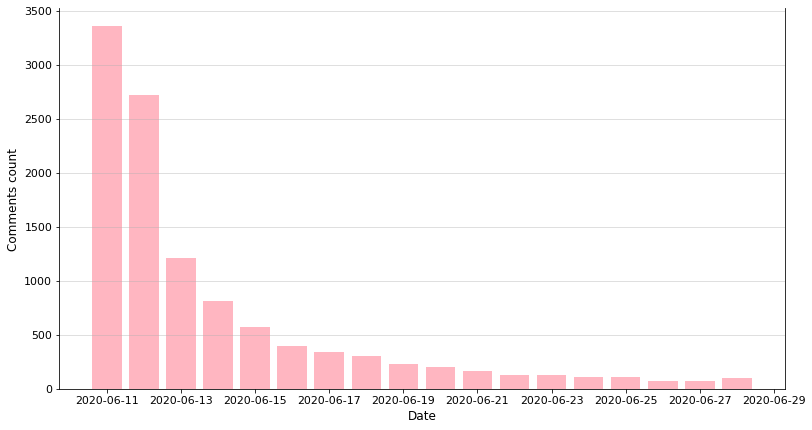

In [21]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(13, 7))

axarr.bar(daily_comment_nb_df.index, daily_comment_nb_df.comments_count, color='lightpink')

axarr.tick_params(labelsize=11)
axarr.set_xlabel('Date', size=12)
axarr.set_ylabel('Comments count', size=12)
axarr.grid(axis='y', which='major', alpha=0.5)
axarr.spines['top'].set_visible(False)

# plt.savefig('daily_comments_count.png', bbox_inches='tight')

This plot describes the daily comments count since the release. Attention that the video is released at 16h on 11 June 2020 (Central European Summer Time, GMT+2), which means there are nearly 3500 comments during 8 hours after release !! Afterwards, the comments count decrease with time, but around 100 comments per day.

### Comments during 24 hours after release

In [22]:
comments_df['comment_updatedAt'].min()

'2020-06-11T16:00:12Z'

In [23]:
comments_24h_df = comments_df[comments_df['comment_updatedAt'] <= '2020-06-12T16:00:00Z']

In [24]:
comments_24h_df['comment_update_min'] = comments_24h_df.apply(
    lambda row: datetime(row['comment_updateDate'].year, row['comment_updateDate'].month,
                         row['comment_updateDate'].day, row['comment_updateTime'].hour,
                         row['comment_updateTime'].minute // 5 * 5, 0), axis='columns')


/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [25]:
nbcomments_5mins = comments_24h_df.groupby(['comment_update_min'])['id'].nunique().to_frame()
nbcomments_5mins = nbcomments_5mins.rename(columns={'id':'nbComments'})


In [26]:
nbcomments_5mins

,nbComments
comment_update_min,
2020-06-11 16:00:00,383
2020-06-11 16:05:00,267
2020-06-11 16:10:00,212
2020-06-11 16:15:00,171
2020-06-11 16:20:00,131
2020-06-11 16:25:00,142
2020-06-11 16:30:00,141
2020-06-11 16:35:00,109
2020-06-11 16:40:00,108


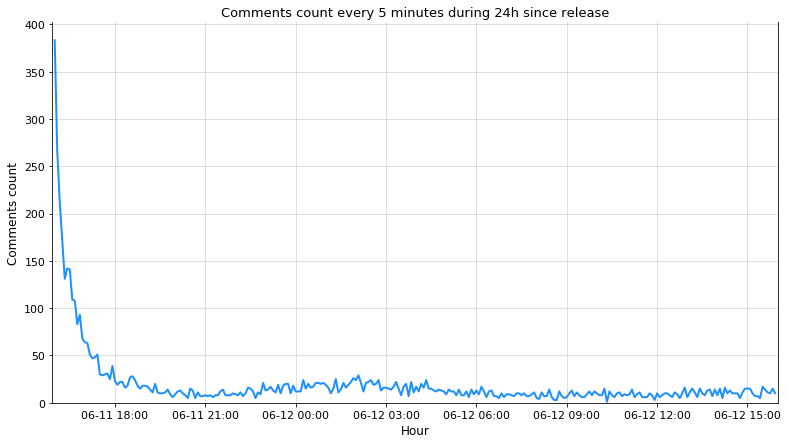

In [27]:
import matplotlib.dates as mdates
hours = mdates.HourLocator(interval=3)
h_fmt = mdates.DateFormatter('%m-%d %H:%M')

fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(13, 7))

axarr.set_title('Comments count every 5 minutes during 24h since release', fontdict={'fontsize': 13})
axarr.plot(nbcomments_5mins.index, nbcomments_5mins.nbComments, color='dodgerblue', lw=2)

axarr.tick_params(labelsize=11)
axarr.set_xlabel('Hour', size=12)
axarr.set_ylabel('Comments count', size=12)
axarr.set_xlim(datetime(2020, 6, 11, 15, 55, 0), datetime(2020, 6, 12, 16, 0, 0))
axarr.set_ylim(0)
axarr.xaxis.set_major_locator(hours)
axarr.xaxis.set_major_formatter(h_fmt)

axarr.grid(which='major', alpha=0.5)
axarr.spines['top'].set_visible(False)

# plt.savefig('first24h_comments_count.png', bbox_inches='tight')

Here I zoom the first 24 hours since the release, show the comment counts of every 5 minutes with this graph. The first comment is posted only 12 seconds after release! There are 383 comments during the first 5 minutes since release. The amount decreases with time, but it has around 15 - 20 comments per 5 minutes after 18h on 11 June 2020.

### Words cloud

In [28]:
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langdetect import detect
import string

from PIL import Image
from wordcloud import WordCloud

In [29]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/jingwen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jingwen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
comments_light_df = comments_df.dropna(subset=['comment_VO'])[['id', 'comment_updatedAt', 'comment_updateDate',
                                                               'comment_updateTime', 'comment_VO']]
comments_light_df = comments_light_df[comments_light_df['id'].isin(
    ['UgzBVuAEy5RHo8_qPTB4AaABAg', 'UgwAeC9F_N4vKYKk4UZ4AaABAg',
     'UgwzTW8SMCaJCsRONfB4AaABAg', 'Ugyb_zzwLtRxOlw3hTZ4AaABAg'])==False]


In [31]:
def detect_lang(s):
    try:
        lang = detect(s)
    except:
        lang = 'Cannot be detected.'
    return lang

In [32]:
%%time
comments_light_df['lang'] = comments_light_df['comment_VO'].apply(lambda x: detect_lang(x))
comments_light_df.loc[((comments_light_df['lang'] == 'id') &
                       (comments_light_df['comment_updateDate'] == date(2020, 6, 11)) &
                       (comments_light_df['comment_updateTime'] <= time(22, 51, 35))), 'lang'] = 'zh-cn'


CPU times: user 1min 22s, sys: 1.19 s, total: 1min 23s
Wall time: 1min 26s


In [ ]:
comments_light_df.lang.unique()

In [ ]:
# # http://uzairadamjee.com/blog/textblob/
# # https://blog.csdn.net/ziyonghong/article/details/83928347
# # https://github.com/AakashChugh/Sentiment-Analysis-using-Python/blob/master/Sentiment_analysis_Python.ipynb
# # https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis

# from textblob import TextBlob
# from snownlp import SnowNLP

# def sentiment_analysis(lang, comment):
#     if lang == 'en':
#         return TextBlob(comment).sentiment[0]
#     elif lang == 'Cannot be detected.':
#         return 0
#     elif lang in ['zh-cn', 'ko', 'zh-tw', 'lt']:
#         return SnowNLP(comment).sentiments
#     else:
#         try:
#             return TextBlob(comment).translate(to='en').sentiment[0]
#         except:
#             return 0

# def comments_pos_neg(lang, note):
#     if lang in ['zh-cn', 'ko', 'zh-tw', 'lt']:
#         if note > 0.7:
#             return 'positive'
#         elif note < 0.3:
#             return 'negative'
#         else:
#             return 'neuter'
#     else:
#         if note > 0.5:
#             return 'positive'
#         elif note < -0.5:
#             return 'negative'
#         else:
#             return 'neuter'



In [ ]:
# %%time
# comments_light_df['sentiment'] = comments_light_df.apply(
#     lambda row: sentiment_analysis(row['lang'], row['comment_VO']), axis='columns')

# comments_light_df['pos_neg'] = comments_light_df.apply(
#     lambda row: comments_pos_neg(row['lang'], row['sentiment']), axis='columns')


In [ ]:
comments_light_df.head()

In [ ]:
# comments_cn_pos = comments_light_df[(comments_light_df['lang'].isin(['zh-cn', 'ko', 'zh-tw', 'lt'])) &
#                                     (comments_light_df['pos_neg'] == 'positive')]
# comments_not_cn_pos = comments_light_df[(comments_light_df['lang'].isin(['zh-cn', 'ko', 'zh-tw', 'lt'])==False) &
#                                         (comments_light_df['pos_neg'] == 'positive')]

# comments_cn_neg = comments_light_df[(comments_light_df['lang'].isin(['zh-cn', 'ko', 'zh-tw', 'lt'])) &
#                                     (comments_light_df['pos_neg'] == 'negative')]
# comments_not_cn_neg = comments_light_df[(comments_light_df['lang'].isin(['zh-cn', 'ko', 'zh-tw', 'lt'])==False) &
#                                         (comments_light_df['pos_neg'] == 'negative')]


In [33]:
comments_cn_df = comments_light_df[comments_light_df['lang'].isin(['zh-cn', 'ko', 'zh-tw', 'lt'])]
comments_not_cn_df = comments_light_df[comments_light_df['lang'].isin(['zh-cn', 'ko', 'zh-tw', 'lt'])==False]

In [58]:
sw_en = stopwords.words('english')
sw_fr = stopwords.words('french')

# https://github.com/stopwords-iso/stopwords-zh/blob/master/stopwords-zh.txt
stop_words = sw_en + sw_fr + ['https', 'http', 'youtube', 'com', 'com watch', 'watch', 'www', 'song', 'and',
                              'it', 'the', 'youtu', 'be', 'thi', 'insta', 'akbarfit', '而我的咖啡', '糖不用太多',
                              '麻烦给我的爱人来一杯Mojito', '铁铸的招牌', '错落着就像', '一封封城市', '献给天空的情书',
                              '当街灯亮起', '當街燈亮起', 'Havana漫步', 'havana漫步', '这是世上最美丽的那双人舞',
                              '这世界已经因为她甜得过头', ' ', '，', '。', ' ，', ' 。', '“', '”', '!', '！', '？',
                              ' ？', '?', ':', '/', ' _', ' ！', '~', '[', '!', '"', '一', '\n', '......', 'v',
                              'V', '=', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '～', '✝', '(', ')',
                              '.....', '@', '《', '》', '-', '哈利', 'Dt4IBR3HRQI', '神仙', 'be', '.', 'UwxatzcYf9Q',
                              ']', '这首歌', '這首歌', '都', '那', '那个', '阿弥陀佛', '虽', '虽然', '致', '自', '的',
                              '一直', '一首', '周杰伦', '杰伦', '周杰倫', '杰倫', '一个', '这个', '一些', '一', '一转眼',
                              '不仅', '好好', '只有', '还是', '還是', '且', '这么', '为什么', '么', '也', '了', '得', '地',
                              '着', '二', '于', '在', '些', '们', '呢', '啊', '呀', '人', '们', '任', '在', '会', '你',
                              '我', '他', '她', '它', '我们', '你们', '他们', '她们', '它们', '大家', '俺', '俺们', '儿',
                              '哈哈哈哈', 'watch', 'bXu', 'nnjrvz8', '路亚', 'UKeGPLFG0U4', '升天', '2fdJFVTSEOo',
                              '驾鶴', 'oy6gjGKqNC8', 'i5QO', 'PqL7z8', 'u3000', '\u3000', '1q2AEYpBbG0',
                              'linw3357', '2020', '2021', '2022', '2023', '2024', '2025', '22751731', '0930358081',
                              'line', 'Z2wkX70kDAw', '李老師', '\r\n', '02', '上西天', '就是', '周蕫', '真的', 'jay chou',
                              'Jay Chou', 'Jay chou', 'Jay', 'jay', 'chou']


**only cn comments**

In [43]:
# https://github.com/fxsjy/jieba
import jieba
# jieba.enable_paddle()

In [44]:
cn_comments = ''
for c in comments_cn_df['comment_VO']:
    cn_comments += (c + ' ')

# cn_pos_comments = ''
# for c in comments_cn_pos['comment_VO']:
#     cn_pos_comments += (c + ' ')

# cn_neg_comments = ''
# for c in comments_cn_neg['comment_VO']:
#     cn_neg_comments += (c + ' ')


In [45]:
my_words = ['周蕫', '結婚後', '美少女戰士', '主題曲', '慵懶曲調', '麻烦给我的爱人来一杯Mojito', '麻烦给我的爱人来一杯mojito',
            '麻烦给我的爱人来一杯', '铁铸的招牌', '错落着就像', '一封封城市', '献给天空的情书', '当街灯亮起', '當街燈亮起',
            'Havana漫步', 'havana漫步', '这是世上最美丽的那双人舞', '这世界已经因为她甜得过头', '牛逼', '90後', '这首歌',
            '這首歌']
for i in my_words:
    jieba.add_word(i)

word_num = jieba.lcut(cn_comments, cut_all=False)
# word_num_pos = jieba.lcut(cn_pos_comments, cut_all=False)
# word_num_neg = jieba.lcut(cn_neg_comments, cut_all=False)

In [46]:
cn_txt = ''
for t in word_num:
    if not t in stop_words:
        cn_txt += (t + ' ')

# cn_pos_txt = ''
# for t in word_num_pos:
#     if not t in stop_words:
#         cn_pos_txt += (t + ' ')

# cn_neg_txt = ''
# for t in word_num_neg:
#     if not t in stop_words:
#         cn_neg_txt += (t + ' ')


In [ ]:
# cn_txt

In [47]:
# https://www.google.fr/search?q=chat+logo+white+background&tbm=isch&ved=2ahUKEwiShIu9kZrqAhUB_BoKHZxkCZsQ2-cCegQIABAA&oq=chat+logo+white+background&gs_lcp=CgNpbWcQAzoECAAQEzoICAAQBxAeEBM6BggAEAcQHjoICAAQBxAFEB46CAgAEAgQBxAeUL_EQFifykBg5s5AaABwAHgAgAFHiAH1AZIBATSYAQCgAQGqAQtnd3Mtd2l6LWltZw&sclient=img&ei=oRzzXtKvLIH4a5zJpdgJ&bih=826&biw=1440#imgrc=femkTVmL6Y9ooM
comments_mask = np.array(Image.open('chat_logo.jpg'))


In [48]:
wordcloud_cn = WordCloud(font_path='/Library/Fonts/simhei.ttf',
                          width=1280, height=1280, margin=0,
                          stopwords=stop_words,
                                  colormap='autumn', #'Oranges',
                                  max_words=100000000,
                                  mask=comments_mask).generate(cn_txt)

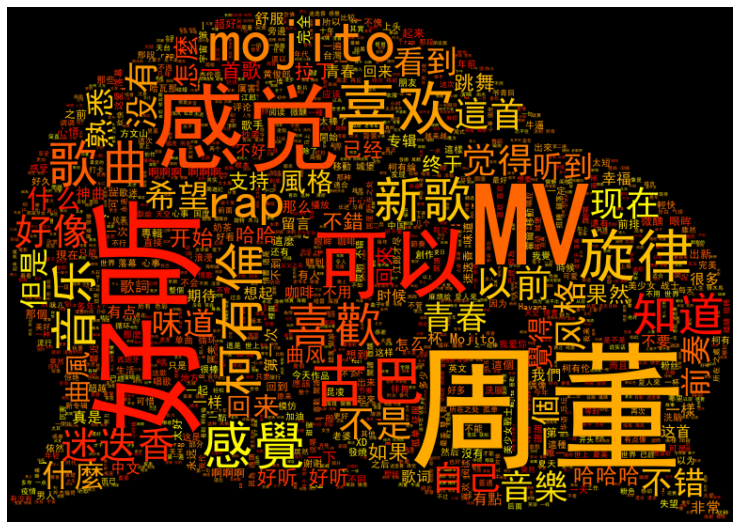

In [49]:
plt.figure(figsize=(13, 13))
plt.imshow(wordcloud_cn, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

# plt.savefig('comments_cn.png', bbox_inches='tight')

**not cn comments**

In [ ]:
# not_cn_comments = ''

# for c in comments_not_cn_df['comment_VO']:
#     not_cn_comments += (c + ' ')

In [50]:
not_cn_text = ' '.join(comments_not_cn_df['comment_VO'].values).lower()

not_cn_txt_tokens = word_tokenize(not_cn_text, 'english')
not_cn_txt_tokens = list(filter(lambda token: token not in string.punctuation, not_cn_txt_tokens))
not_cn_txt_tokens = list(filter(lambda token: token not in stop_words, not_cn_txt_tokens))

In [ ]:
# # pos(not cn)
# not_cn_pos_text = ' '.join(comments_not_cn_pos['comment_VO'].values).lower()

# not_cn_pos_txt_tokens = word_tokenize(not_cn_pos_text, 'english')
# not_cn_pos_txt_tokens = list(filter(lambda token: token not in string.punctuation, not_cn_pos_txt_tokens))
# not_cn_pos_txt_tokens = list(filter(lambda token: token not in stop_words, not_cn_pos_txt_tokens))

In [ ]:
# # neg(not cn)
# not_cn_neg_text = ' '.join(comments_not_cn_neg['comment_VO'].values).lower()

# not_cn_neg_txt_tokens = word_tokenize(not_cn_neg_text, 'english')
# not_cn_neg_txt_tokens = list(filter(lambda token: token not in string.punctuation, not_cn_neg_txt_tokens))
# not_cn_neg_txt_tokens = list(filter(lambda token: token not in stop_words, not_cn_neg_txt_tokens))

In [51]:
freq_not_cn_txt_tokens = nltk.FreqDist(not_cn_txt_tokens)
# freq_not_cn_txt_tokens.plot(20, cumulative=False)

# freq_not_cn_pos_txt_tokens = nltk.FreqDist(not_cn_pos_txt_tokens)
# freq_not_cn_neg_txt_tokens = nltk.FreqDist(not_cn_neg_txt_tokens)

In [52]:
not_cn_txt = nltk.Text(not_cn_txt_tokens)
# not_cn_pos_txt = nltk.Text(not_cn_pos_txt_tokens)
# not_cn_neg_txt = nltk.Text(not_cn_neg_txt_tokens)

In [53]:
bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(not_cn_txt_tokens)
trigram_finder = nltk.collocations.TrigramCollocationFinder.from_words(not_cn_txt_tokens)
quadgram_finder = nltk.collocations.QuadgramCollocationFinder.from_words(not_cn_txt_tokens)

bigrams = sorted(bigram_finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))
trigrams = sorted(trigram_finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))
quadgrams = sorted(quadgram_finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))

df_bigrams = pd.DataFrame({' '.join(l[0]):l[1] for l in bigrams}, index=['count']).T
df_trigrams = pd.DataFrame({' '.join(l[0]):l[1] for l in trigrams}, index=['count']).T
df_quadgrams = pd.DataFrame({' '.join(l[0]):l[1] for l in quadgrams}, index=['count']).T


In [ ]:
# # pos(not cn)
# bigram_pos_finder = nltk.collocations.BigramCollocationFinder.from_words(not_cn_pos_txt_tokens)
# trigram_pos_finder = nltk.collocations.TrigramCollocationFinder.from_words(not_cn_pos_txt_tokens)
# quadgram_pos_finder = nltk.collocations.QuadgramCollocationFinder.from_words(not_cn_pos_txt_tokens)

# bigrams_pos = sorted(bigram_pos_finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))
# trigrams_pos = sorted(trigram_pos_finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))
# quadgrams_pos = sorted(quadgram_pos_finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))

# df_bigrams_pos = pd.DataFrame({' '.join(l[0]):l[1] for l in bigrams_pos}, index=['count']).T
# df_trigrams_pos = pd.DataFrame({' '.join(l[0]):l[1] for l in trigrams_pos}, index=['count']).T
# df_quadgrams_pos = pd.DataFrame({' '.join(l[0]):l[1] for l in quadgrams_pos}, index=['count']).T


In [ ]:
# # neg(not cn)
# bigram_neg_finder = nltk.collocations.BigramCollocationFinder.from_words(not_cn_neg_txt_tokens)
# trigram_neg_finder = nltk.collocations.TrigramCollocationFinder.from_words(not_cn_neg_txt_tokens)
# quadgram_neg_finder = nltk.collocations.QuadgramCollocationFinder.from_words(not_cn_neg_txt_tokens)

# bigrams_neg = sorted(bigram_neg_finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))
# trigrams_neg = sorted(trigram_neg_finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))
# quadgrams_neg = sorted(quadgram_neg_finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))

# df_bigrams_neg = pd.DataFrame({' '.join(l[0]):l[1] for l in bigrams_neg}, index=['count']).T
# df_trigrams_neg = pd.DataFrame({' '.join(l[0]):l[1] for l in trigrams_neg}, index=['count']).T
# df_quadgrams_neg = pd.DataFrame({' '.join(l[0]):l[1] for l in quadgrams_neg}, index=['count']).T


In [54]:
bigrams_txt = ''
for txt, cnt in df_bigrams.iterrows():
    bigrams_txt += (txt + ' ') * int(cnt)


trigrams_txt = ''
for txt, cnt in df_trigrams.iterrows():
    trigrams_txt += (txt + ' ') * int(cnt)


quadgrams_txt = ''
for txt, cnt in df_quadgrams.iterrows():
    quadgrams_txt += (txt + ' ') * int(cnt)


In [ ]:
# bigrams_pos_txt = ''
# for txt, cnt in df_bigrams_pos.iterrows():
#     bigrams_pos_txt += (txt + ' ') * int(cnt)


# trigrams_pos_txt = ''
# for txt, cnt in df_trigrams_pos.iterrows():
#     trigrams_pos_txt += (txt + ' ') * int(cnt)


# quadgrams_pos_txt = ''
# for txt, cnt in df_quadgrams_pos.iterrows():
#     quadgrams_pos_txt += (txt + ' ') * int(cnt)


In [ ]:
# bigrams_neg_txt = ''
# for txt, cnt in df_bigrams_neg.iterrows():
#     bigrams_neg_txt += (txt + ' ') * int(cnt)


# trigrams_neg_txt = ''
# for txt, cnt in df_trigrams_neg.iterrows():
#     trigrams_neg_txt += (txt + ' ') * int(cnt)


# quadgrams_neg_txt = ''
# for txt, cnt in df_quadgrams_neg.iterrows():
#     quadgrams_neg_txt += (txt + ' ') * int(cnt)


In [55]:
# https://www.google.fr/search?q=jay+chou+logo&tbm=isch&ved=2ahUKEwjDpZ2tjJrqAhWUwoUKHRxPC0QQ2-cCegQIABAA&oq=jay+chou+logo&gs_lcp=CgNpbWcQAzIECAAQE1Ck0whYjtYIYN_XCGgAcAB4AIABwAGIAdACkgEDMy4xmAEAoAEBqgELZ3dzLXdpei1pbWc&sclient=img&ei=QhfzXsP8EZSFlwScnq2gBA&bih=826&biw=1440#imgrc=e5qmK-0-nr-vMM&imgdii=4p_FGFC0_sCI8M
jay_mask = np.array(Image.open('jay_logo.jpg'))


In [59]:
wordcloud_3type_grams = WordCloud(font_path='/Library/Fonts/simhei.ttf',
                                  width=1280, height=1280, margin=0,
                                  colormap='spring', #'Oranges',
                                  stopwords=stop_words,
                                  max_words=100000000,
                                  mask=jay_mask).generate(bigrams_txt + trigrams_txt + quadgrams_txt)

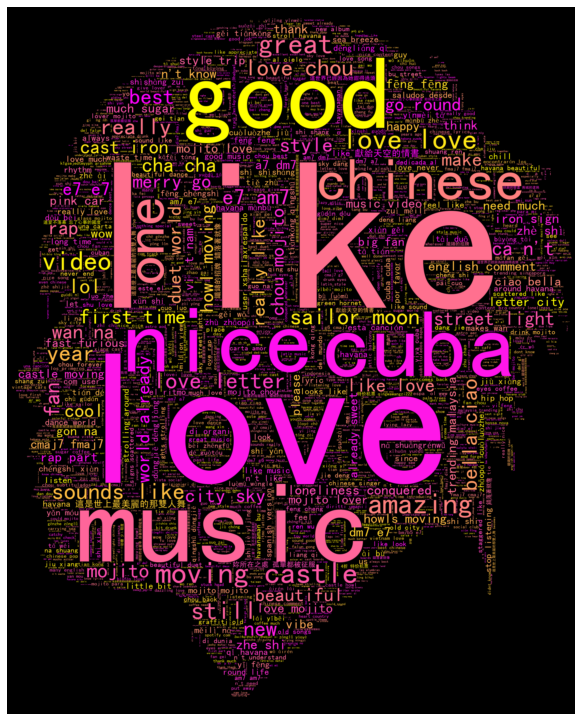

In [60]:
plt.figure(figsize=(13, 13))
plt.imshow(wordcloud_3type_grams, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

# plt.savefig('comments_not_cn.png', bbox_inches='tight')

**all comments**

In [62]:
# https://static4.depositphotos.com/1004221/347/i/950/depositphotos_3479588-stock-photo-mojito-cocktail-on-white-background.jpg
mojito_mask = np.array(Image.open('mojito_logo.jpg'))

In [63]:
wordcloud_all = WordCloud(font_path='/Library/Fonts/simhei.ttf',
                          width=1280, height=1280, margin=0,
                          stopwords=stop_words,
                          colormap='summer',
                          max_words=100000000,
                          mask=mojito_mask).generate(cn_txt + bigrams_txt + trigrams_txt + quadgrams_txt)

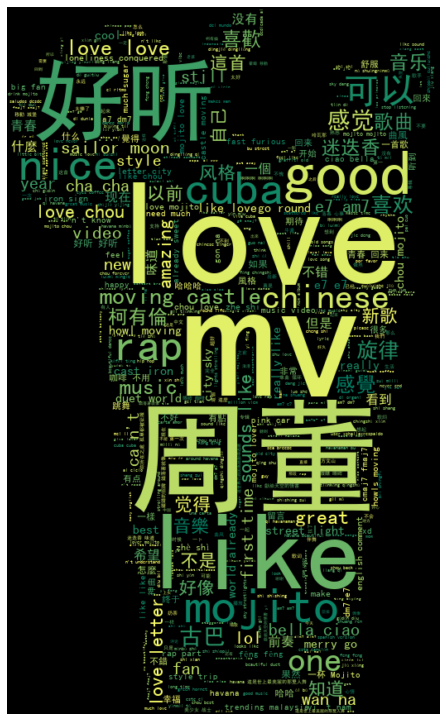

In [65]:
plt.figure(figsize=(13, 13))
plt.imshow(wordcloud_all, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)

# plt.savefig('comments_all.png', bbox_inches='tight')

**positive comments**

In [ ]:
# # https://www.google.fr/search?q=like+logo+white+background&tbm=isch&ved=2ahUKEwiW4ebVrqLqAhXH_4UKHYsPBEUQ2-cCegQIABAA&oq=like+logo+white+ba&gs_lcp=CgNpbWcQARgAMgQIABATOgQIABBDOgIIADoECAAQHjoGCAAQHhATOggIABAIEB4QE1C05zRYgfQ0YJX9NGgAcAB4AIABQIgBtwOSAQE5mAEAoAEBqgELZ3dzLXdpei1pbWc&sclient=img&ei=_Gz3XpbzBcf_lwSLn5CoBA&bih=1366&biw=2560#imgrc=y8lRvg-O-MpsMM&imgdii=7smPkhKSoH7StM
# like_mask = np.array(Image.open('like_logo.jpg'))

# wordcloud_pos = WordCloud(font_path='/Library/Fonts/simhei.ttf',
#                           width=1280, height=1280, margin=0,
#                           stopwords=stop_words,
#                           colormap='summer',
#                           max_words=100000000,
#                           mask=like_mask).generate(cn_pos_txt + bigrams_pos_txt + trigrams_pos_txt + quadgrams_pos_txt)


# plt.figure(figsize=(13, 13))
# plt.imshow(wordcloud_pos, interpolation="bilinear")
# plt.axis("off")
# plt.margins(x=0, y=0)

# # plt.savefig('comments_all.png', bbox_inches='tight')

**negative comments**

In [ ]:
# # 
# dislike_mask = np.array(Image.open('dislike_logo.jpg'))


# wordcloud_neg = WordCloud(font_path='/Library/Fonts/simhei.ttf',
#                           width=1280, height=1280, margin=0,
#                           stopwords=stop_words,
#                           colormap='YlOrRd',
#                           max_words=100000000,
#                           mask=dislike_mask).generate(cn_neg_txt + bigrams_neg_txt + trigrams_neg_txt + quadgrams_neg_txt)


# plt.figure(figsize=(13, 13))
# plt.imshow(wordcloud_neg, interpolation="bilinear")
# plt.axis("off")
# plt.margins(x=0, y=0)

# # plt.savefig('comments_all.png', bbox_inches='tight')